# **Indian Market Pairs Trading: Statistical Arbitrage Framework.**

# Made By -[Ranadip Manna](https://github.com/RanadipM/Machine_Learning_Projects.) & [Yuvraj Sharma](https://github.com/uvee3t)

1. Project Overview
This project implements an end-to-end algorithmic trading pipeline designed to exploit price inefficiencies between historically correlated stocks. By combining Machine Learning (to find similar stocks) with Time-Series Econometrics (to verify their relationship), the system identifies high-probability trading opportunities that remain market-neutral.

2. Key Objectives
   Data Acquisition: Automated ingestion of historical price data and fundamental metrics for 90+ Indian tickers across 10 sectors (Banking, IT, Auto, Energy, etc.) using yfinance.

   Pair Identification: Using Unsupervised Learning (K-Means Clustering) and PCA to group stocks with similar characteristics, reducing the search space for potential pairs.

   Statistical Validation: Rigorous testing using the Engle-Granger Cointegration Test and Augmented Dickey-Fuller (ADF) tests to ensure the price spread is stationary.

   Backtesting Engine: A custom-built simulation logic to calculate entry/exit signals (Z-Score based), equity curves, and risk metrics.

3. Technical Workflow
   Feature Engineering: Extracting returns, volatility, and fundamental ratios (P/E, ROE, Market Cap).

   Dimensionality Reduction: Applying PCA to handle multicollinearity in stock features.

   Clustering: Segmenting stocks into clusters to identify "statistical neighbors."

   Cointegration Analysis: Testing every possible pair within a cluster for a long-term equilibrium relationship.

   Strategy Simulation: Generating trade logs including entry/exit dates, net returns, and portfolio growth.

4. Tech Stack
   Language: Python

   Libraries: pandas, numpy (Data Processing), statsmodels (Time-series Analysis), scikit-learn (ML/Clustering), yfinance (Market Data), seaborn/matplotlib (Visualization).

5. Output
   The notebook generates two primary artifacts used by the Streamlit application:

   fundamentals.csv: Processed sector-wise stock information.

   trade_df.csv: A comprehensive log of backtested trades and cumulative returns for identified pairs.

# Data Preparation

In [1]:
#1
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
#2
SECTORS = {
    "IT": [
        "TCS.NS","INFY.NS","WIPRO.NS","HCLTECH.NS","TECHM.NS",
        "LTIM.NS","MPHASIS.NS","COFORGE.NS","PERSISTENT.NS","OFSS.NS"
    ],
    "BANKING": [
        "HDFCBANK.NS","ICICIBANK.NS","AXISBANK.NS","SBIN.NS","KOTAKBANK.NS",
        "INDUSINDBK.NS","BANDHANBNK.NS","FEDERALBNK.NS","IDFCFIRSTB.NS","PNB.NS"
    ],
    "FMCG": [
        "HINDUNILVR.NS","ITC.NS","NESTLEIND.NS","DABUR.NS","BRITANNIA.NS",
        "MARICO.NS","GODREJCP.NS","COLPAL.NS","UBL.NS","TATACONSUM.NS"
    ],
    "PHARMA": [
        "SUNPHARMA.NS","DRREDDY.NS","CIPLA.NS","DIVISLAB.NS","LUPIN.NS",
        "BIOCON.NS","TORNTPHARM.NS","ALKEM.NS","AUROPHARMA.NS","GLENMARK.NS"
    ],
    "AUTO": [
        "MARUTI.NS","TATAMOTORS.NS","M&M.NS","BAJAJ-AUTO.NS","EICHERMOT.NS",
        "HEROMOTOCO.NS","TVSMOTOR.NS","ASHOKLEY.NS","ESCORTS.NS","BALKRISIND.NS"
    ],
    "METAL": [
        "TATASTEEL.NS","JSWSTEEL.NS","HINDALCO.NS","SAIL.NS","NMDC.NS",
        "VEDL.NS","RATNAMANI.NS","APLAPOLLO.NS","COALINDIA.NS","JINDALSTEL.NS"
    ],
    "ENERGY": [
        "RELIANCE.NS","ONGC.NS","BPCL.NS","IOC.NS","HINDPETRO.NS",
        "GAIL.NS","POWERGRID.NS","NTPC.NS","ADANIGREEN.NS","TATAPOWER.NS"
    ],
    "INFRA": [
        "LT.NS","ADANIPORTS.NS","DLF.NS","GMRINFRA.NS","IRB.NS",
        "NBCC.NS","NCC.NS","SIEMENS.NS","KEC.NS","ASHOKA.NS"
    ],
    "FINANCIALS": [
        "BAJFINANCE.NS","BAJAJFINSV.NS","HDFCLIFE.NS","SBILIFE.NS","ICICIPRULI.NS",
        "CHOLAFIN.NS","MUTHOOTFIN.NS","MANAPPURAM.NS","PFC.NS","REC.NS"
    ],
    "CHEMICALS": [
        "PIDILITIND.NS","UPL.NS","SRF.NS","TATACHEM.NS","AARTIIND.NS",
        "DEEPAKNTR.NS","NAVINFLUOR.NS","BALRAMCHIN.NS","ALKYLAMINE.NS","GNFC.NS"
    ]
}

In [3]:
#3
def safe(value, div=1, precision=2):
    if value is None or value == 0 or value != value:
        return np.nan
    try:
        return round(value/div, precision)
    except:
        return np.nan

In [4]:
#4
def get_ticker(ticker_name):
    t = yf.Ticker(ticker_name)
    return t

In [5]:
#5
def get_one_year_return(ticker_object):
    try:
        data = ticker_object.history(period="1y")

        if len(data) < 2:
            return np.nan

        first_price = data["Close"].iloc[0]
        last_price = data["Close"].iloc[-1]

        price_change = last_price - first_price
        pct_return = (price_change / first_price) * 100

        pct_return = round(pct_return, 2)

        return pct_return
    except Exception:
        return np.nan

In [6]:
#6
def get_growth_values(ticker_object):
    rev_growth = np.nan
    eps_growth = np.nan
    try:
        earnings = ticker_object.earnings

        if earnings is None:
            return rev_growth, eps_growth

        if len(earnings) < 2:
            return rev_growth, eps_growth

        prev_rev = earnings.iloc[-2]["Revenue"]
        curr_rev = earnings.iloc[-1]["Revenue"]

        rev_change = curr_rev - prev_rev
        rev_growth = (rev_change / prev_rev) * 100
        rev_growth = round(rev_growth, 2)

        prev_eps = earnings.iloc[-2]["Earnings"]
        curr_eps = earnings.iloc[-1]["Earnings"]

        eps_change = curr_eps - prev_eps
        eps_growth = (eps_change / prev_eps) * 100
        eps_growth = round(eps_growth, 2)

        return rev_growth, eps_growth
    except Exception:
        return np.nan, np.nan

In [7]:
#7
def get_profit_ratios(info):

    roe = safe(info.get("returnOnEquity"), 0.01)
    roa = safe(info.get("returnOnAssets"), 0.01)
    net_margin = safe(info.get("profitMargins"), 0.01)

    return roe, roa, net_margin

In [8]:
#8
def get_debt_equity(info):

    debt_to_equity = np.nan

    debt = info.get("totalDebt")
    equity = info.get("totalStockholderEquity")

    if debt is not None and equity is not None and equity != 0:
        ratio = debt / equity
        debt_to_equity = ratio * 100
        debt_to_equity = round(debt_to_equity, 2)

    return debt_to_equity

In [9]:
#9
def fetch_fundamentals(ticker_name, sector_name):
    t = get_ticker(ticker_name)
    info = t.info
    if not info:
        return None

    one_year = get_one_year_return(t)
    rev_growth, eps_growth = get_growth_values(t)

    roe, roi, net_margin = get_profit_ratios(info)
    debt_equity = get_debt_equity(info)
    fundamentals = {}

    fundamentals["Sector"] = sector_name
    fundamentals["Ticker"] = ticker_name.replace(".NS","")

    fundamentals["Market Cap (Cr)"] = safe(info.get("marketCap"), 1e7)
    fundamentals["PE Ratio"] = safe(info.get("trailingPE"))

    fundamentals["1Y Return %"] = one_year

    fundamentals["ROE %"] = roe
    fundamentals["ROI %"] = roi
    fundamentals["Net Profit Margin %"] = net_margin
    fundamentals["Debt/Equity %"] = debt_equity

    fundamentals["1Y Revenue Growth %"] = rev_growth
    fundamentals["1Y EPS Growth %"] = eps_growth

    fundamentals["Dividend Yield %"] = safe(info.get("dividendYield"), 0.01)

    fundamentals["EBITDA (Cr)"] = safe(info.get("ebitda"), 1e7)
    fundamentals["Cash & Equiv (Cr)"] = safe(info.get("totalCash"), 1e7)
    fundamentals["Total Debt (Cr)"] = safe(info.get("totalDebt"), 1e7)

    fundamentals["Beta"] = safe(info.get("beta"))

    return fundamentals

In [10]:
#10
def download_data(sectors, start_date, end_date, base_folder):
    for sector, stocks in sectors.items():
        folder_path = os.path.join(base_folder, sector)
        os.makedirs(folder_path, exist_ok=True)

        for ticker in stocks:
            print(f"Downloading {ticker} | {start_date} to {end_date}")

            df = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                progress=False
            )

            if df.empty:
                print(f" No data for {ticker}")
                continue

            file_name = ticker.replace(".NS", "") + ".csv"
            df.to_csv(os.path.join(folder_path, file_name))

# Traning Data

In [11]:
#11
download_data(
    sectors=SECTORS,
    start_date="2021-01-01",
    end_date="2024-12-31",
    base_folder="DATA_TRAIN_2023_2024"
)


1 Failed download:
['COFORGE.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2024-12-31) (Yahoo error = "Error occurred while retrieving timeseries, keys: [RedisKey [key=TF[1,YF_HIST,DV][0P0000ALY6], cluster=finance]]")')


 No data for COFORGE.NS



1 Failed download:
['MARUTI.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2024-12-31) (Yahoo error = "Request Failed")')


 No data for MARUTI.NS



1 Failed download:
['TATAMOTORS.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")')


 No data for TATAMOTORS.NS



1 Failed download:
['GMRINFRA.NS']: YFTzMissingError('possibly delisted; no timezone found')


 No data for GMRINFRA.NS


HTTP Error 404: 

1 Failed download:
['REC.NS']: YFTzMissingError('possibly delisted; no timezone found')


 No data for REC.NS


# Testing Data

In [12]:
#12
download_data(
    sectors=SECTORS,
    start_date="2025-01-01",
    end_date="2025-12-1",
    base_folder="DATA_TEST_2025"
)


1 Failed download:
['TATAMOTORS.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-01-01 -> 2025-12-1) (Yahoo error = "No data found, symbol may be delisted")')


 No data for TATAMOTORS.NS



1 Failed download:
['GMRINFRA.NS']: YFTzMissingError('possibly delisted; no timezone found')


 No data for GMRINFRA.NS



1 Failed download:
['REC.NS']: YFTzMissingError('possibly delisted; no timezone found')


 No data for REC.NS


# Data Preprocessing

In [13]:
#13
def load_prices(folder_path):
    prices = {}

    for sector in os.listdir(folder_path):
        sector_path = os.path.join(folder_path, sector)

        if os.path.isdir(sector_path):
            for file in os.listdir(sector_path):
                if file.endswith(".csv"):
                    stock = file.replace(".csv", "")
                    df = pd.read_csv(os.path.join(sector_path, file))
                    df.rename(columns={df.columns[0]: "Date"}, inplace=True)

                    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
                    df = df.dropna(subset=["Date"])

                    df.set_index("Date", inplace=True)
                    prices[stock] = pd.to_numeric(df["Close"], errors='coerce')

    return pd.DataFrame(prices)

In [14]:
#14
price_train = load_prices("DATA_TRAIN_2023_2024").apply(pd.to_numeric, errors="coerce").dropna(axis=1).astype(float)
price_train.head()

ASHOKLEY   BAJAJ-AUTO   BALKRISIND    EICHERMOT      ESCORTS  \
Date                                                                        
2021-01-01  45.300316  3044.287109  1575.494385  2424.213379  1253.024048   
2021-01-04  47.563046  3080.315674  1606.820068  2531.947754  1276.813721   
2021-01-05  47.883026  3054.255859  1613.247803  2550.252930  1277.738037   
2021-01-06  48.043018  3028.065430  1611.185059  2522.079834  1259.445679   
2021-01-07  50.762867  3006.422119  1600.055664  2526.322754  1281.532715   

             HEROMOTOCO         M&M       MARUTI    TVSMOTOR    AXISBANK  ...  \
Date                                                                      ...   
2021-01-01  2610.592773  698.754883  7371.631348  478.680511  621.206238  ...   
2021-01-04  2561.118164  714.638916  7382.174316  483.264954  622.102478  ...   
2021-01-05  2580.764893  706.052917  7337.271973  479.607147  661.687256  ...   
2021-01-06  2594.521729  702.236938  7311.537598  476.144440  651.529602  ...   
2021-01-07  2570.709961  710.155151  7251.586914  487.020233  668.309570  ...   

                  ALKEM  AUROPHARMA      BIOCON       CIPLA     DIVISLAB  \
Date                                                                       
2021-01-01  2802.553223  899.210876  461.055176  796.180664  3733.721436   
2021-01-04  2818.177490  936.041992  462.292572  801.622803  3746.526367   
2021-01-05  2834.181396  949.223633  462.936005  796.806763  3726.979980   
2021-01-06  2834.607910  939.046570  455.115601  794.446960  3763.598389   
2021-01-07  2856.500488  927.997314  450.215515  796.132568  3689.099609   

                DRREDDY    GLENMARK        LUPIN   SUNPHARMA   TORNTPHARM  
Date                                                                       
2021-01-01  1015.833618  493.645874   974.582153  566.247375  1310.864746  
2021-01-04  1021.822327  505.432037   999.947144  573.987244  1310.677246  
2021-01-05  1024.661743  508.476837  1012.605408  573.085083  1317.618286  
2021-01-06  1024.933105  510.981476   974.289978  574.841980  1308.824707  
2021-01-07  1021.560791  505.186554   995.370728  571.613220  1301.906982  

[5 rows x 97 columns]

In [15]:
#15
price_test = (
    load_prices("DATA_TEST_2025")
        .apply(pd.to_numeric, errors="coerce")
        .dropna(axis=1)
        .astype(float)
)

In [16]:
#16
common_cols = price_train.columns.intersection(price_test.columns)

train_prices = price_train[common_cols]
test_prices  = price_test[common_cols]

In [17]:
#17
train_prices.shape

(986, 97)

In [18]:
#18
test_prices.shape

(227, 97)

In [19]:
#19
train_prices.describe()

ASHOKLEY    BAJAJ-AUTO   BALKRISIND    EICHERMOT      ESCORTS  \
count  986.000000    986.000000   986.000000   986.000000   986.000000   
mean    74.637779   5076.990971  2279.129897  3287.051201  2269.533584   
std     19.496962   2465.894184   392.742628   796.757478   889.753690   
min     45.300316   2809.345947  1480.617310  2164.313232  1088.393188   
25%     59.559749   3393.763367  2027.564362  2592.981201  1544.567963   
50%     68.120033   3657.320068  2238.281982  3182.705688  1990.930969   
75%     83.438490   6474.058960  2485.062805  3746.032776  3021.476135   
max    126.768326  12353.318359  3316.004639  4997.795898  4336.909668   

        HEROMOTOCO          M&M        MARUTI     TVSMOTOR     AXISBANK  ...  \
count   986.000000   986.000000    986.000000   986.000000   986.000000  ...   
mean   3075.346852  1418.658317   8986.537941  1272.785423   895.475926  ...   
std    1037.752321   703.243680   1883.336693   710.251522   181.385325  ...   
min    1953.396484   666.197266   6187.337891   476.144440   621.206238  ...   
25%    2384.318787   823.292267   7327.011841   625.455368   738.279968  ...   
50%    2540.153809  1232.632629   8512.017578  1042.272583   861.841827  ...   
75%    3724.966309  1616.999023  10340.038574  1952.551422  1053.623199  ...   
max    5949.071777  3168.841309  13351.095703  2937.518799  1316.175171  ...   

             ALKEM   AUROPHARMA      BIOCON        CIPLA     DIVISLAB  \
count   986.000000   986.000000  986.000000   986.000000   986.000000   
mean   3779.054826   836.875171  315.533676  1092.083968  4005.982517   
std     995.440981   297.826410   58.478647   244.882650   757.050891   
min    2466.852051   398.404419  197.014633   727.360168  2699.876953   
25%    3028.322632   596.171021  263.482063   901.169434  3490.573792   
50%    3360.260376   815.207886  322.319046   998.230286  3710.414673   
75%    4737.392212  1021.088013  361.404274  1240.848877  4466.499390   
max    6305.968750  1563.530884  466.994659  1662.738037  6228.140625   

           DRREDDY     GLENMARK        LUPIN    SUNPHARMA   TORNTPHARM  
count   986.000000   986.000000   986.000000   986.000000   986.000000  
mean   1009.877126   718.164414  1112.803134  1054.987379  1862.305721  
std     169.865127   383.828884   461.611647   369.984859   670.789127  
min     724.066895   347.809967   577.935852   535.952576  1118.592651  
25%     863.974762   441.331741   739.187668   792.231018  1395.006378  
50%     953.962708   545.696869   974.436066   952.865631  1520.710083  
75%    1143.271057   850.044525  1295.032532  1235.157959  2232.371521  
max    1403.588257  1813.701294  2297.063477  1930.670654  3523.016113  

[8 rows x 97 columns]

In [20]:
#20
test_prices.describe()

ASHOKLEY   BAJAJ-AUTO   BALKRISIND    EICHERMOT      ESCORTS  \
count  227.000000   227.000000   227.000000   227.000000   227.000000   
mean   119.628756  8396.269854  2510.214182  5751.052547  3392.651623   
std     14.977048   504.225436   160.422228   758.813371   230.472505   
min     95.702293  7126.193848  2208.120117  4643.144531  2853.608398   
25%    106.396873  8123.851074  2365.927612  5249.186035  3247.422607   
50%    119.002922  8394.256836  2506.409668  5458.225586  3379.600098   
75%    132.521240  8782.000000  2657.783813  6637.750000  3573.099976   
max    159.750000  9433.500000  2874.093018  7258.500000  3847.800049   

        HEROMOTOCO          M&M        MARUTI     TVSMOTOR     AXISBANK  ...  \
count   227.000000   227.000000    227.000000   227.000000   227.000000  ...   
mean   4473.755528  3145.180225  13234.347673  2882.744820  1124.763099  ...   
std     740.010093   329.776132   1713.598373   444.850389    86.482344  ...   
min    3441.068115  2471.394531  11088.287109  2167.611572   947.290405  ...   
25%    3889.881104  2913.195312  11939.795898  2474.993896  1055.700012  ...   
50%    4251.299805  3124.993652  12480.914062  2796.500000  1131.599976  ...   
75%    5301.000000  3422.300049  15011.000000  3411.399902  1197.476562  ...   
max    6174.500000  3757.300049  16424.000000  3658.300049  1290.199951  ...   

             ALKEM   AUROPHARMA      BIOCON        CIPLA     DIVISLAB  \
count   227.000000   227.000000  227.000000   227.000000   227.000000   
mean   5138.277043  1139.984482  357.330626  1495.634608  6171.651242   
std     319.400470    60.096638   24.670904    52.151654   407.342924   
min    4556.206543  1022.200012  302.046173  1370.064453  5235.112793   
25%    4866.146240  1096.099976  338.397552  1460.869446  5861.112061   
50%    5069.488770  1135.537476  356.399994  1494.599976  6112.716309   
75%    5429.000000  1179.696716  372.375000  1526.196228  6558.822510   
max    5773.000000  1348.189209  421.600006  1663.599976  6951.845703   

           DRREDDY     GLENMARK        LUPIN    SUNPHARMA   TORNTPHARM  
count   227.000000   227.000000   227.000000   227.000000   227.000000  
mean   1234.671475  1699.230696  1997.629253  1692.574893  3373.766177  
std      64.385952   273.963460    89.190199    65.401766   226.757396  
min    1081.043945  1275.820557  1851.800049  1561.360229  2924.743164  
25%    1192.760315  1436.925476  1940.400024  1649.234436  3193.282959  
50%    1243.314697  1649.154907  1975.016357  1687.544800  3322.399902  
75%    1280.652954  1935.875488  2046.037170  1734.095337  3580.699951  
max    1366.384277  2221.251709  2381.289551  1872.464233  3831.800049  

[8 rows x 97 columns]

In [21]:
#21
train_prices.isnull().sum().sum()

np.int64(0)

In [22]:
#21
test_prices.isnull().sum().sum()

np.int64(0)

In [23]:
#22
train_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 986 entries, 2021-01-01 to 2024-12-30
Data columns (total 97 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ASHOKLEY    986 non-null    float64
 1   BAJAJ-AUTO  986 non-null    float64
 2   BALKRISIND  986 non-null    float64
 3   EICHERMOT   986 non-null    float64
 4   ESCORTS     986 non-null    float64
 5   HEROMOTOCO  986 non-null    float64
 6   M&M         986 non-null    float64
 7   MARUTI      986 non-null    float64
 8   TVSMOTOR    986 non-null    float64
 9   AXISBANK    986 non-null    float64
 10  BANDHANBNK  986 non-null    float64
 11  FEDERALBNK  986 non-null    float64
 12  HDFCBANK    986 non-null    float64
 13  ICICIBANK   986 non-null    float64
 14  IDFCFIRSTB  986 non-null    float64
 15  INDUSINDBK  986 non-null    float64
 16  KOTAKBANK   986 non-null    float64
 17  PNB         986 non-null    float64
 18  SBIN        986 non-null    float64
 19  AARTIIND  

In [24]:
#23
test_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227 entries, 2025-01-01 to 2025-11-28
Data columns (total 97 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ASHOKLEY    227 non-null    float64
 1   BAJAJ-AUTO  227 non-null    float64
 2   BALKRISIND  227 non-null    float64
 3   EICHERMOT   227 non-null    float64
 4   ESCORTS     227 non-null    float64
 5   HEROMOTOCO  227 non-null    float64
 6   M&M         227 non-null    float64
 7   MARUTI      227 non-null    float64
 8   TVSMOTOR    227 non-null    float64
 9   AXISBANK    227 non-null    float64
 10  BANDHANBNK  227 non-null    float64
 11  FEDERALBNK  227 non-null    float64
 12  HDFCBANK    227 non-null    float64
 13  ICICIBANK   227 non-null    float64
 14  IDFCFIRSTB  227 non-null    float64
 15  INDUSINDBK  227 non-null    float64
 16  KOTAKBANK   227 non-null    float64
 17  PNB         227 non-null    float64
 18  SBIN        227 non-null    float64
 19  AARTIIND  

In [25]:
#24
train_prices["start"] = train_prices.index[0]
train_prices["end"]   = train_prices.index[-1]
print(train_prices)

              ASHOKLEY   BAJAJ-AUTO   BALKRISIND    EICHERMOT      ESCORTS  \
Date                                                                         
2021-01-01   45.300316  3044.287109  1575.494385  2424.213379  1253.024048   
2021-01-04   47.563046  3080.315674  1606.820068  2531.947754  1276.813721   
2021-01-05   47.883026  3054.255859  1613.247803  2550.252930  1277.738037   
2021-01-06   48.043018  3028.065430  1611.185059  2522.079834  1259.445679   
2021-01-07   50.762867  3006.422119  1600.055664  2526.322754  1281.532715   
...                ...          ...          ...          ...          ...   
2024-12-23  106.843399  8551.715820  2799.502441  4689.740234  3116.444336   
2024-12-24  107.302116  8561.078125  2791.948730  4731.547852  3128.885742   
2024-12-26  107.429001  8659.045898  2807.403809  4739.890137  3123.879883   
2024-12-27  107.609558  8707.614258  2845.966553  4814.472656  3230.252441   
2024-12-30  109.010132  8562.882812  2833.791260  4793.642578  3

In [26]:
#25
def build_fundamental_feature_table(SECTORS_DICT):

    records = []

    for sector, tickers in SECTORS_DICT.items():
        print(f"\nFetching fundamentals → {sector}")

        for ticker in tickers:
            try:
                row = fetch_fundamentals(ticker, sector)
                if row is not None:
                    records.append(row)
                    print(f"{ticker} done")
                else:
                    print(f"{ticker} failed — Could not fetch valid info.")
            except Exception as e:
                print(f"{ticker} failed — {e}")

    return pd.DataFrame(records)

In [27]:
#26
fundamentals_df = build_fundamental_feature_table(SECTORS)
fundamentals_df.head()


Fetching fundamentals → IT
TCS.NS done
INFY.NS done
WIPRO.NS done
HCLTECH.NS done
TECHM.NS done
LTIM.NS done
MPHASIS.NS done
COFORGE.NS done
PERSISTENT.NS done
OFSS.NS done

Fetching fundamentals → BANKING
HDFCBANK.NS done
ICICIBANK.NS done
AXISBANK.NS done
SBIN.NS done
KOTAKBANK.NS done
INDUSINDBK.NS done
BANDHANBNK.NS done
FEDERALBNK.NS done
IDFCFIRSTB.NS done
PNB.NS done

Fetching fundamentals → FMCG
HINDUNILVR.NS done
ITC.NS done
NESTLEIND.NS done
DABUR.NS done
BRITANNIA.NS done
MARICO.NS done
GODREJCP.NS done
COLPAL.NS done
UBL.NS done
TATACONSUM.NS done

Fetching fundamentals → PHARMA
SUNPHARMA.NS done
DRREDDY.NS done
CIPLA.NS done
DIVISLAB.NS done
LUPIN.NS done
BIOCON.NS done
TORNTPHARM.NS done
ALKEM.NS done
AUROPHARMA.NS done
GLENMARK.NS done

Fetching fundamentals → AUTO
MARUTI.NS done


HTTP Error 404: 
$TATAMOTORS.NS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


TATAMOTORS.NS done
M&M.NS done
BAJAJ-AUTO.NS done
EICHERMOT.NS done
HEROMOTOCO.NS done
TVSMOTOR.NS done
ASHOKLEY.NS done
ESCORTS.NS done
BALKRISIND.NS done

Fetching fundamentals → METAL
TATASTEEL.NS done
JSWSTEEL.NS done
HINDALCO.NS done
SAIL.NS done
NMDC.NS done
VEDL.NS done
RATNAMANI.NS done
APLAPOLLO.NS done
COALINDIA.NS done
JINDALSTEL.NS done

Fetching fundamentals → ENERGY
RELIANCE.NS done
ONGC.NS done
BPCL.NS done
IOC.NS done
HINDPETRO.NS done
GAIL.NS done
POWERGRID.NS done
NTPC.NS done
ADANIGREEN.NS done
TATAPOWER.NS done

Fetching fundamentals → INFRA
LT.NS done
ADANIPORTS.NS done
DLF.NS done


$GMRINFRA.NS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


GMRINFRA.NS done
IRB.NS done
NBCC.NS done
NCC.NS done
SIEMENS.NS done
KEC.NS done
ASHOKA.NS done

Fetching fundamentals → FINANCIALS
BAJFINANCE.NS done
BAJAJFINSV.NS done
HDFCLIFE.NS done
SBILIFE.NS done
ICICIPRULI.NS done
CHOLAFIN.NS done
MUTHOOTFIN.NS done
MANAPPURAM.NS done
PFC.NS done


HTTP Error 404: 
$REC.NS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


REC.NS done

Fetching fundamentals → CHEMICALS
PIDILITIND.NS done
UPL.NS done
SRF.NS done
TATACHEM.NS done
AARTIIND.NS done
DEEPAKNTR.NS done
NAVINFLUOR.NS done
BALRAMCHIN.NS done
ALKYLAMINE.NS done
GNFC.NS done


Sector   Ticker  Market Cap (Cr)  PE Ratio  1Y Return %  ROE %  ROI %  \
0     IT      TCS       1157824.20     24.24       -18.06  42.63  22.51   
1     IT     INFY        674214.29     23.58        -6.23  32.68  15.67   
2     IT    WIPRO        248640.83     18.82       -18.23  15.20   6.74   
3     IT  HCLTECH        467969.66     28.48         5.73  23.19  12.87   
4     IT    TECHM        156106.10     33.78        10.04    NaN    NaN   

   Net Profit Margin %  Debt/Equity %  1Y Revenue Growth %  1Y EPS Growth %  \
0                18.30            NaN                  NaN              NaN   
1                16.15            NaN                  NaN              NaN   
2                14.59            NaN                  NaN              NaN   
3                13.02            NaN                  NaN              NaN   
4                 8.39            NaN                  NaN              NaN   

   Dividend Yield %  EBITDA (Cr)  Cash & Equiv (Cr)  Total Debt (Cr)  Beta  
0             199.0     68208.00            56743.0          10821.0  0.30  
1             267.0       438.05              298.5             97.8  0.26  
2             724.0     16809.90            57394.9          19804.6  0.56  
3             314.0       284.90              349.2             79.1  0.20  
4             258.0      7575.77             7278.9           1954.4  0.21

In [28]:
#27
fundamentals_df.shape

(100, 16)

In [29]:
#28
fundamentals_df.isnull().sum().sum()

np.int64(394)

In [30]:
#30
fundamentals_df.isnull().sum()

Sector                   0
Ticker                   0
Market Cap (Cr)          3
PE Ratio                 4
1Y Return %              3
ROE %                   23
ROI %                   23
Net Profit Margin %      3
Debt/Equity %          100
1Y Revenue Growth %    100
1Y EPS Growth %        100
Dividend Yield %         6
EBITDA (Cr)             18
Cash & Equiv (Cr)        3
Total Debt (Cr)          4
Beta                     4
dtype: int64

In [31]:
#31
fundamentals_df.describe()

Market Cap (Cr)   PE Ratio  1Y Return %      ROE %      ROI %  \
count     9.700000e+01   96.00000    97.000000  77.000000  77.000000   
mean      2.202107e+05   36.29250    14.405670  19.359091   7.330390   
std       2.991391e+05   23.27039    27.169287  14.084053   5.878547   
min       4.129960e+03    2.99000   -39.110000   1.640000   0.360000   
25%       6.038545e+04   20.33250    -3.470000  11.420000   3.660000   
50%       1.147340e+05   30.38000    10.040000  15.920000   6.050000   
75%       2.492154e+05   50.66500    32.000000  23.670000  10.110000   
max       1.890080e+06  103.37000    95.510000  81.970000  33.480000   

       Net Profit Margin %  Debt/Equity %  1Y Revenue Growth %  \
count            97.000000            0.0                  0.0   
mean             15.318144            NaN                  NaN   
std              14.397312            NaN                  NaN   
min             -14.660000            NaN                  NaN   
25%               6.310000            NaN                  NaN   
50%              12.000000            NaN                  NaN   
75%              18.300000            NaN                  NaN   
max              94.920000            NaN                  NaN   

       1Y EPS Growth %  Dividend Yield %   EBITDA (Cr)  Cash & Equiv (Cr)  \
count              0.0         94.000000      82.00000          97.000000   
mean               NaN        158.244681   14627.28378       21619.975361   
std                NaN        171.757561   24775.56962       53867.164140   
min                NaN          5.000000     284.90000          10.560000   
25%                NaN         48.500000    2207.41500        1689.000000   
50%                NaN         93.000000    4318.55000        6103.500000   
75%                NaN        185.000000   15301.90000       12801.610000   
max                NaN        736.000000  168450.99000      413643.440000   

       Total Debt (Cr)       Beta  
count     9.600000e+01  96.000000  
mean      6.798871e+04   0.343958  
std       1.505701e+05   0.252847  
min       3.200000e-01  -0.280000  
25%       1.125415e+03   0.177500  
50%       5.762515e+03   0.305000  
75%       6.484190e+04   0.485000  
max       1.006498e+06   1.090000

In [32]:
#32
fundamentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sector               100 non-null    object 
 1   Ticker               100 non-null    object 
 2   Market Cap (Cr)      97 non-null     float64
 3   PE Ratio             96 non-null     float64
 4   1Y Return %          97 non-null     float64
 5   ROE %                77 non-null     float64
 6   ROI %                77 non-null     float64
 7   Net Profit Margin %  97 non-null     float64
 8   Debt/Equity %        0 non-null      float64
 9   1Y Revenue Growth %  0 non-null      float64
 10  1Y EPS Growth %      0 non-null      float64
 11  Dividend Yield %     94 non-null     float64
 12  EBITDA (Cr)          82 non-null     float64
 13  Cash & Equiv (Cr)    97 non-null     float64
 14  Total Debt (Cr)      96 non-null     float64
 15  Beta                 96 non-null     floa

In [33]:
#33
fundamentals_df["start"] = fundamentals_df.index[0]
fundamentals_df["end"]   = fundamentals_df.index[-1]
print(fundamentals_df)

       Sector      Ticker  Market Cap (Cr)  PE Ratio  1Y Return %  ROE %  \
0          IT         TCS       1157824.20     24.24       -18.06  42.63   
1          IT        INFY        674214.29     23.58        -6.23  32.68   
2          IT       WIPRO        248640.83     18.82       -18.23  15.20   
3          IT     HCLTECH        467969.66     28.48         5.73  23.19   
4          IT       TECHM        156106.10     33.78        10.04    NaN   
..        ...         ...              ...       ...          ...    ...   
95  CHEMICALS   DEEPAKNTR         21419.16     40.23       -28.12   9.96   
96  CHEMICALS  NAVINFLUOR         30596.27     67.35        68.01  14.63   
97  CHEMICALS  BALRAMCHIN          8273.43     20.47       -13.95  10.85   
98  CHEMICALS  ALKYLAMINE          8089.45     44.45        -2.67    NaN   
99  CHEMICALS        GNFC          6921.64     10.87        -7.03   7.48   

    ROI %  Net Profit Margin %  Debt/Equity %  1Y Revenue Growth %  \
0   22.51        

In [34]:
#34
fundamentals_df = fundamentals_df.drop(
    columns=[
        "Debt/Equity %",
        "1Y Revenue Growth %",
        "1Y EPS Growth %"
    ]
)

# Data Visualization

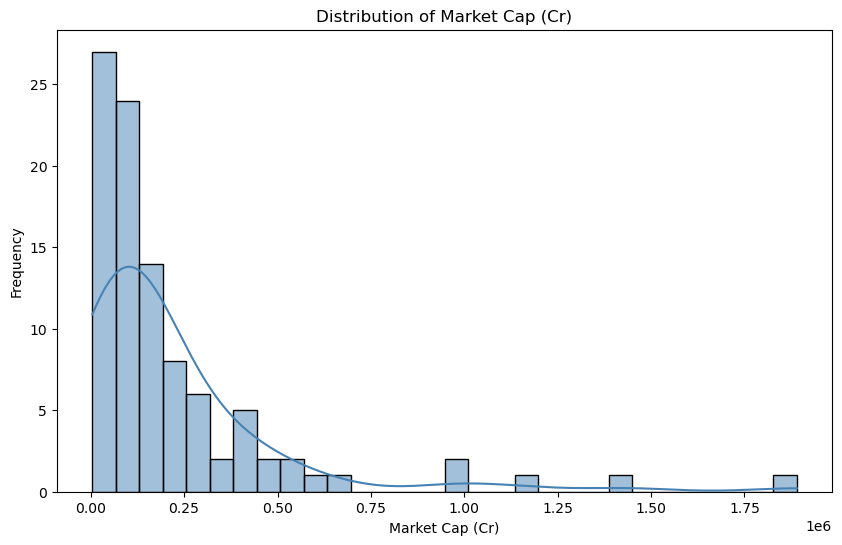

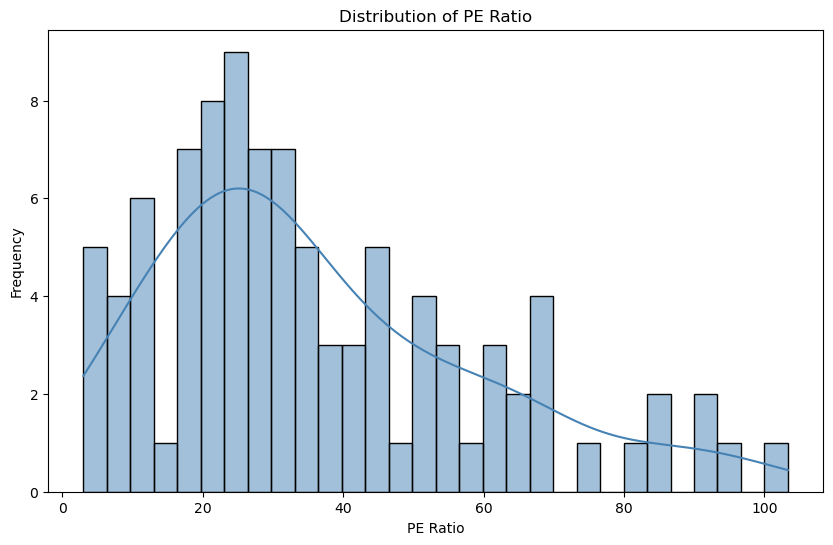

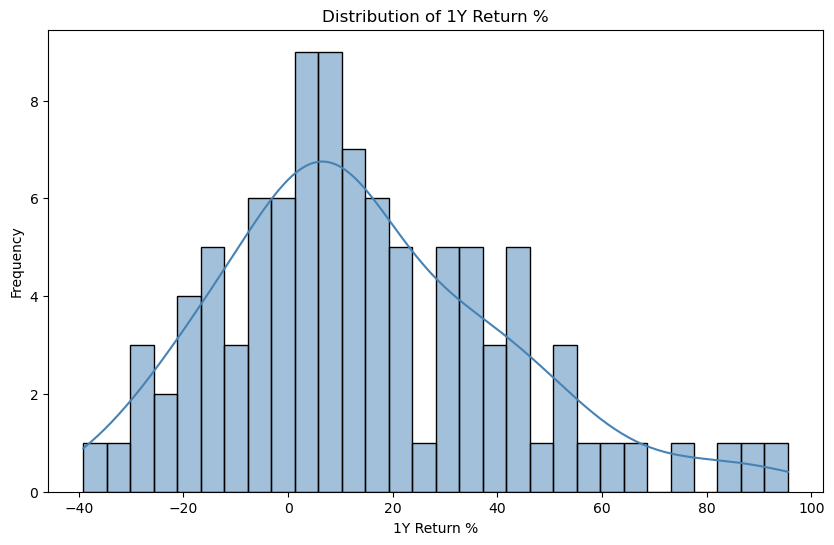

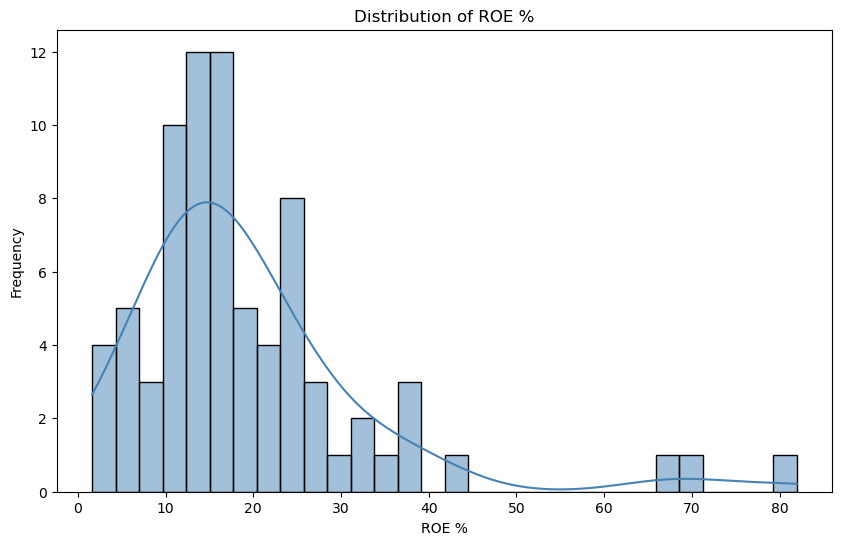

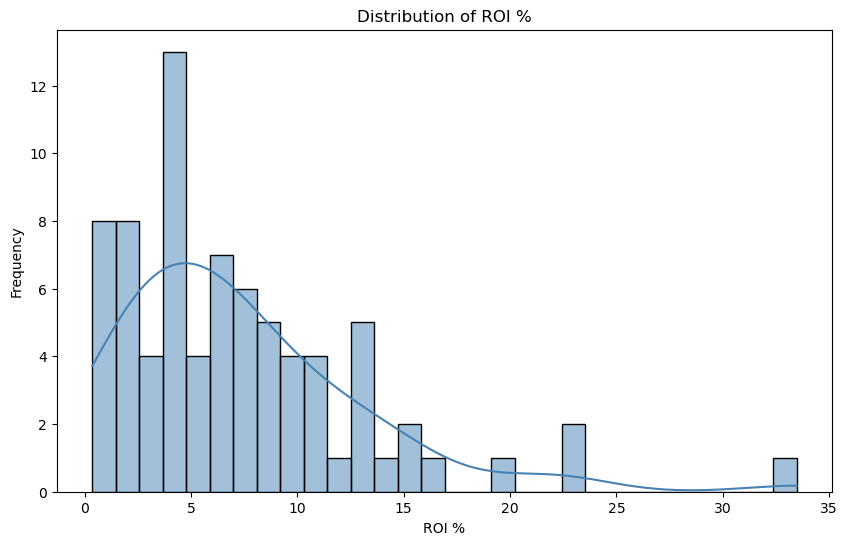

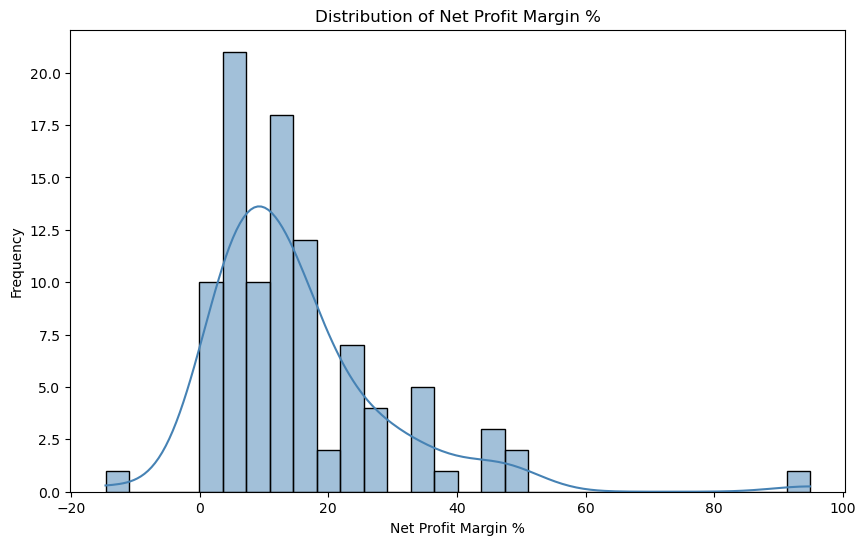

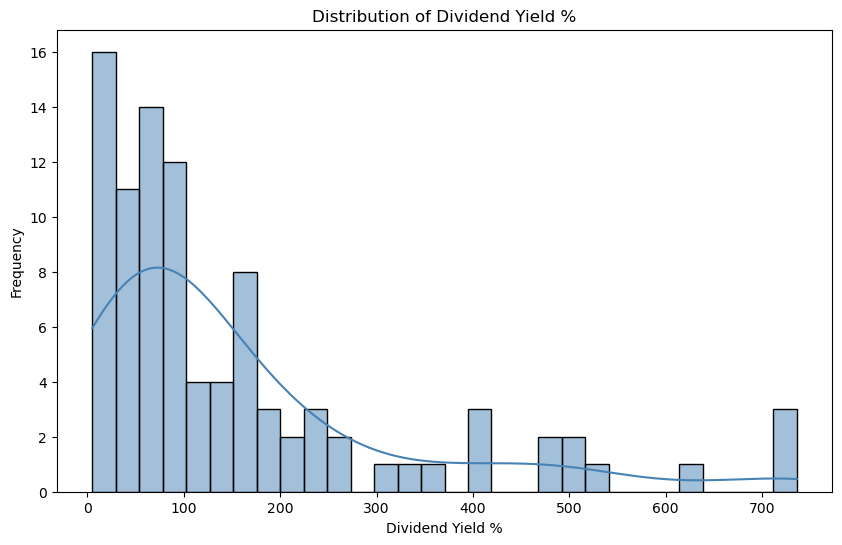

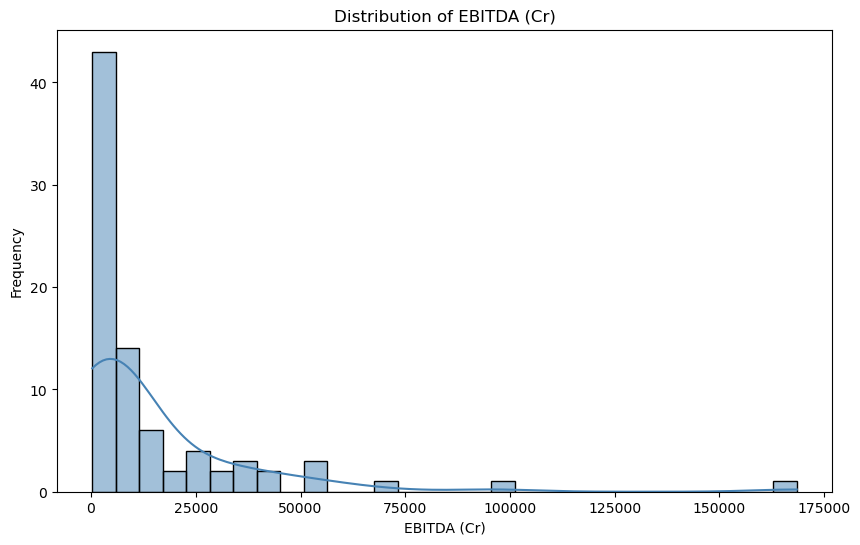

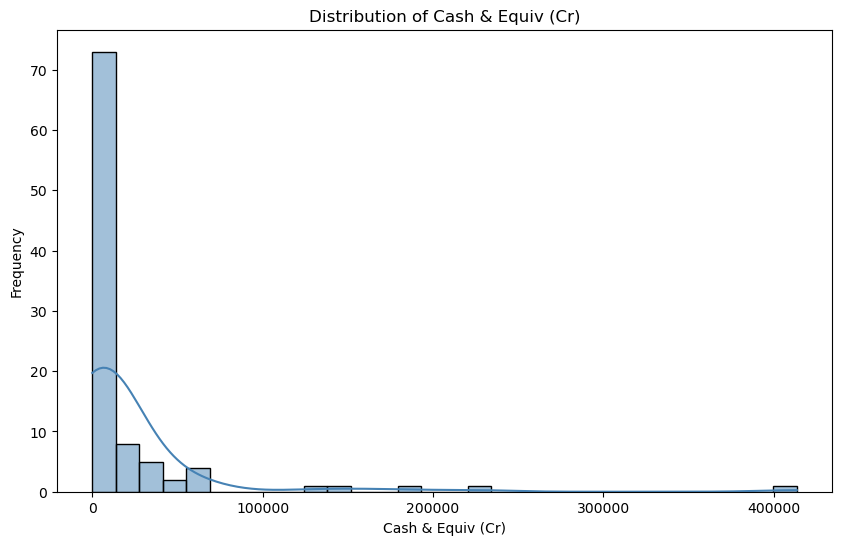

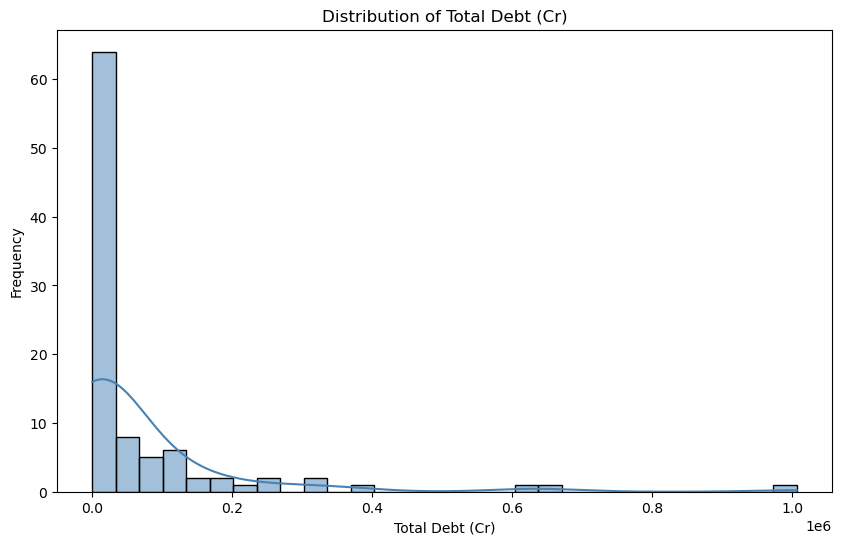

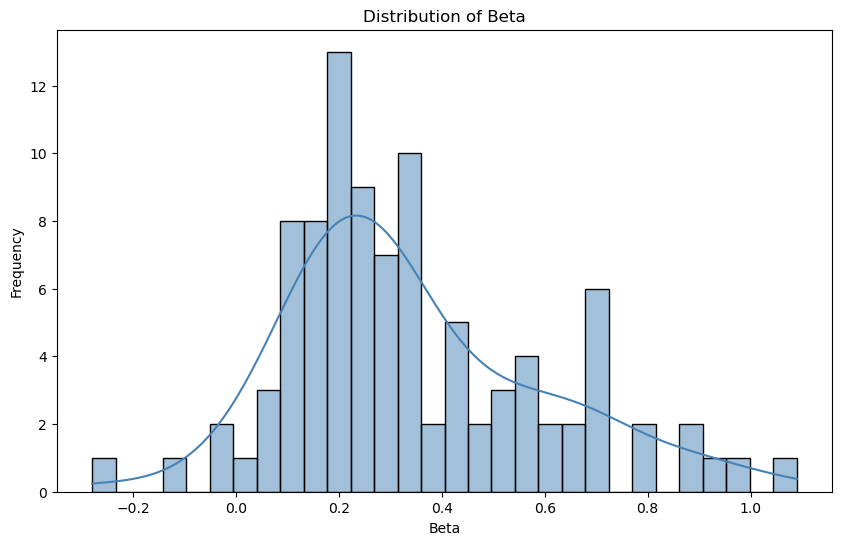

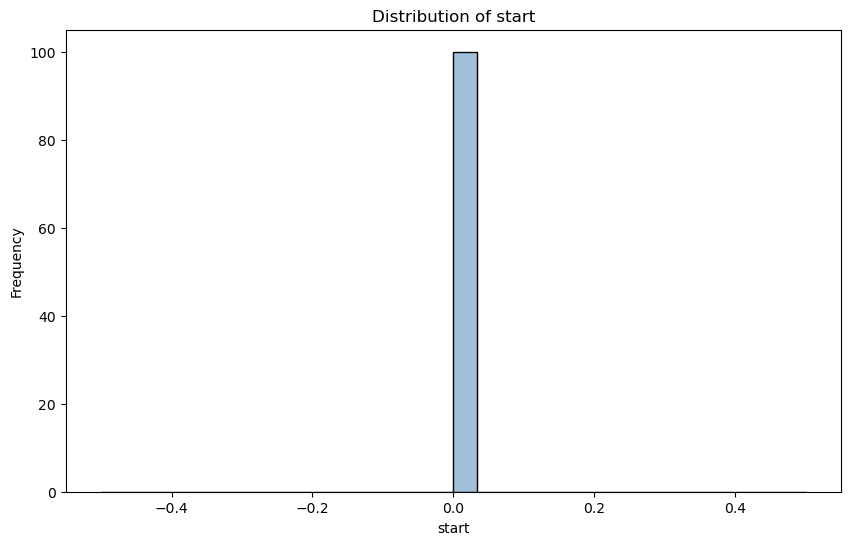

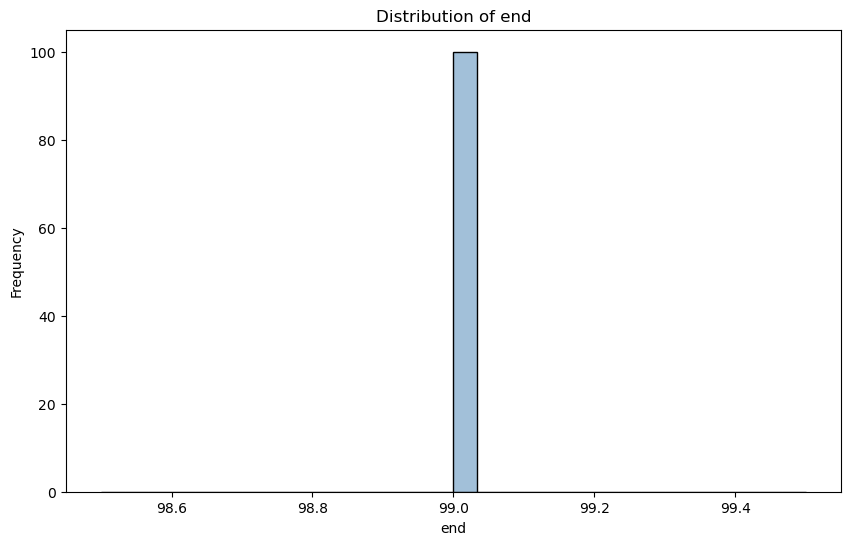

In [35]:
#35
for x in fundamentals_df.columns:
    if fundamentals_df[x].dtype != 'object':
        plt.figure(figsize=(10, 6))
        sns.histplot(
            fundamentals_df[x],
            bins=30,
            kde=True,
            color="steelblue"
        )

        plt.title(f'Distribution of {x}')
        plt.xlabel(x)
        plt.ylabel("Frequency")
        plt.show()

In [36]:
#36
numeric_cols = [
    "Market Cap (Cr)",
    "PE Ratio",
    "1Y Return %",
    "ROE %",
    "ROI %",
    "Net Profit Margin %",
    "Dividend Yield %",
    "EBITDA (Cr)",
    "Cash & Equiv (Cr)",
    "Total Debt (Cr)",
    "Beta"
]

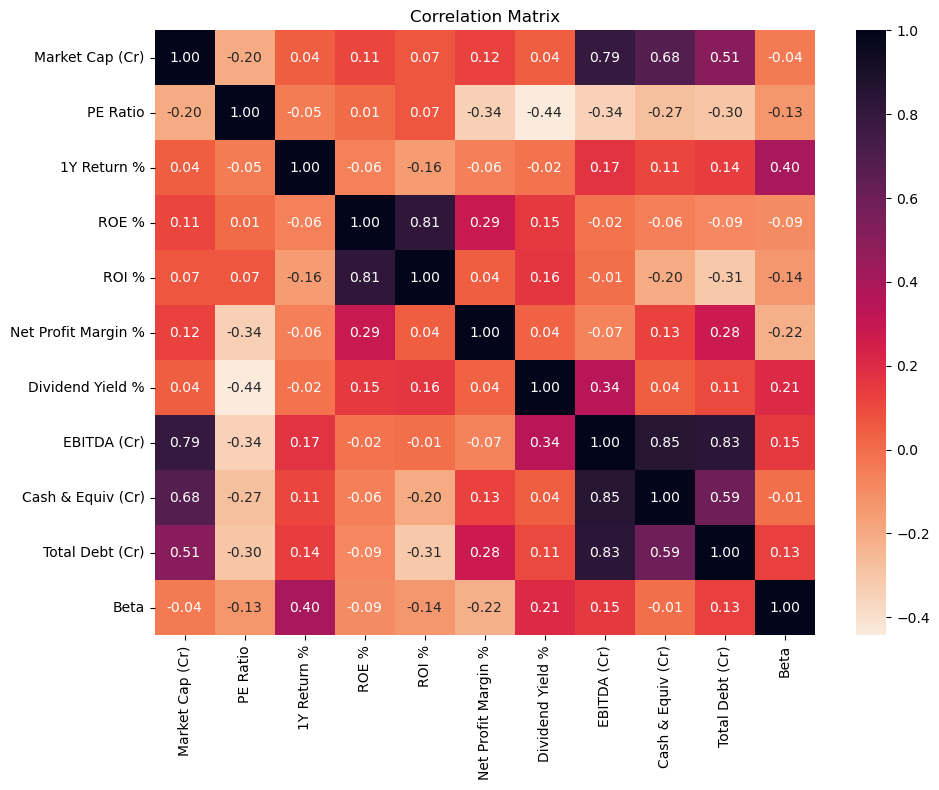

In [37]:
#37
correlation_matrix = fundamentals_df[numeric_cols].corr()
correlation_matrix = correlation_matrix.dropna(axis=0, how='all') \
                                       .dropna(axis=1, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,annot=True,cmap="rocket_r",fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Data Scaling & Normalization

In [38]:
#38
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
fundamental_scaled = scaler.fit_transform(fundamentals_df[numeric_cols])

# PCA

In [39]:
#39
pca = PCA(n_components=0.95)
imputer = SimpleImputer(strategy='median')
fundamental_scaled_imputed = imputer.fit_transform(fundamental_scaled)

fundamental_pca = pca.fit_transform(fundamental_scaled_imputed)
print("Number of PCA components:", pca.n_components_)
print("Explained variance:", pca.explained_variance_ratio_.sum())

Number of PCA components: 6
Explained variance: 0.9506132605051086


# K Means Clustering

In [40]:
#40
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}

for k in range(2,10):
  kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
  clusters = kmeans.fit_predict(fundamental_pca)
  score = silhouette_score(fundamental_pca, clusters)
  sil_scores[k] = score
print(sil_scores)

{2: np.float64(0.7740753721456107), 3: np.float64(0.7309632653197897), 4: np.float64(0.4705931399550545), 5: np.float64(0.45413100396127076), 6: np.float64(0.457484610636339), 7: np.float64(0.3090363736649406), 8: np.float64(0.26794704613130027), 9: np.float64(0.2675228860315282)}


In [41]:
#41
best_k = max(sil_scores, key=sil_scores.get)
print("Best number of clusters =", best_k)

kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=42)
final_clusters = kmeans_final.fit_predict(fundamental_pca)

Best number of clusters = 2


In [42]:
#42
fundamentals_df["fundamental_cluster"] = final_clusters
fundamentals_df.head()

Sector   Ticker  Market Cap (Cr)  PE Ratio  1Y Return %  ROE %  ROI %  \
0     IT      TCS       1157824.20     24.24       -18.06  42.63  22.51   
1     IT     INFY        674214.29     23.58        -6.23  32.68  15.67   
2     IT    WIPRO        248640.83     18.82       -18.23  15.20   6.74   
3     IT  HCLTECH        467969.66     28.48         5.73  23.19  12.87   
4     IT    TECHM        156106.10     33.78        10.04    NaN    NaN   

   Net Profit Margin %  Dividend Yield %  EBITDA (Cr)  Cash & Equiv (Cr)  \
0                18.30             199.0     68208.00            56743.0   
1                16.15             267.0       438.05              298.5   
2                14.59             724.0     16809.90            57394.9   
3                13.02             314.0       284.90              349.2   
4                 8.39             258.0      7575.77             7278.9   

   Total Debt (Cr)  Beta  start  end  fundamental_cluster  
0          10821.0  0.30      0   99                    0  
1             97.8  0.26      0   99                    0  
2          19804.6  0.56      0   99                    0  
3             79.1  0.20      0   99                    0  
4           1954.4  0.21      0   99                    0

In [43]:
#43
fundamentals_df["fundamental_cluster"].value_counts()

fundamental_cluster
0    95
1     5
Name: count, dtype: int64

In [44]:
#44
fundamentals_df.groupby(["fundamental_cluster","Sector"]).size()

fundamental_cluster  Sector    
0                    AUTO          10
                     BANKING        6
                     CHEMICALS     10
                     ENERGY         9
                     FINANCIALS    10
                     FMCG          10
                     INFRA         10
                     IT            10
                     METAL         10
                     PHARMA        10
1                    BANKING        4
                     ENERGY         1
dtype: int64

In [45]:
#45
fundamentals_df.to_csv("FUNDAMENTAL_CLUSTER_OUTPUT.csv", index=False)
print("FUNDAMENTAL_CLUSTER_OUTPUT.csv")

FUNDAMENTAL_CLUSTER_OUTPUT.csv


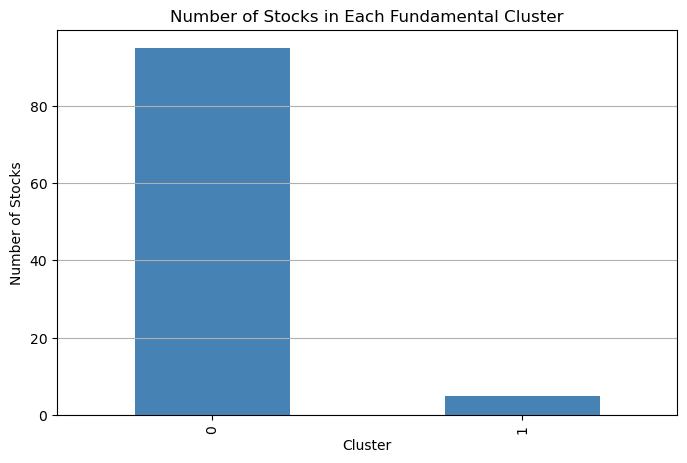

In [46]:
#46
plt.figure(figsize=(8, 5))

fundamentals_df["fundamental_cluster"].value_counts().sort_index().plot(
    kind="bar",
    color="steelblue"
)

plt.title("Number of Stocks in Each Fundamental Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Stocks")
plt.grid(axis="y")
plt.show()

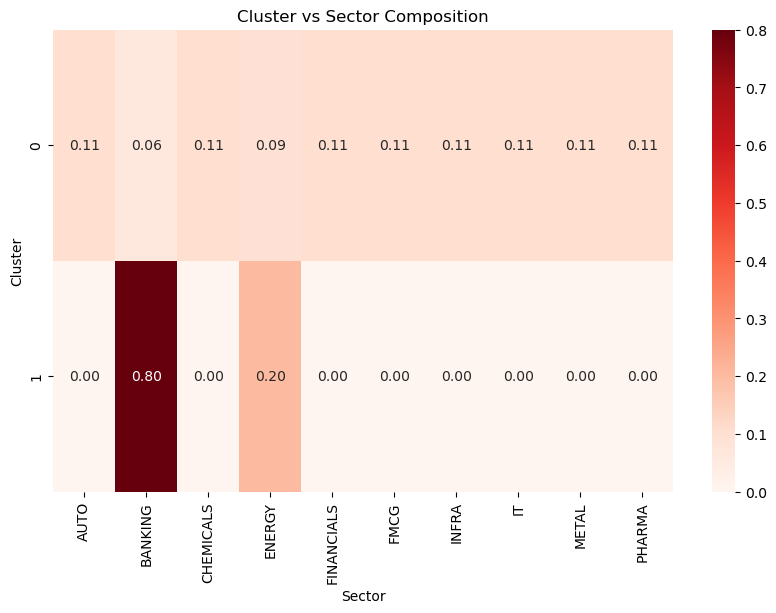

In [47]:
#47
cluster_sector = pd.crosstab(fundamentals_df['fundamental_cluster'], fundamentals_df['Sector'], normalize='index')

plt.figure(figsize=(10,6))
sns.heatmap(cluster_sector, cmap="Reds", annot=True, fmt=".2f")
plt.title("Cluster vs Sector Composition")
plt.xlabel("Sector")
plt.ylabel("Cluster")
plt.show()

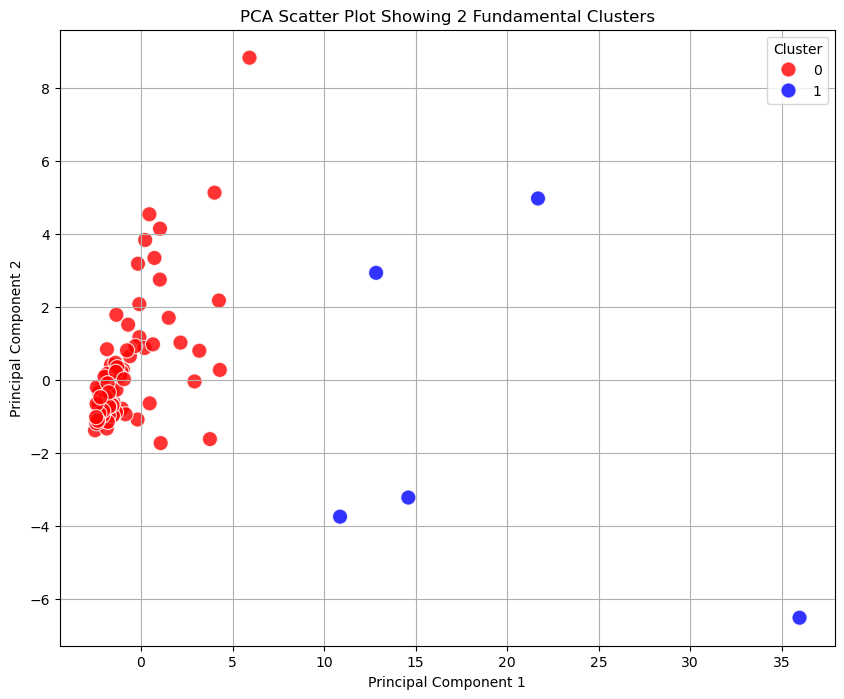

In [48]:
#48
pca_df = pd.DataFrame(
    fundamental_pca[:, :2],
    columns=["PC1", "PC2"]
)
pca_df["Cluster"] = fundamentals_df["fundamental_cluster"]
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette=["red", "blue"],
    s=120,
    alpha=0.8
)

plt.title("PCA Scatter Plot Showing 2 Fundamental Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)

plt.show()

# AgglomerativeClustering

In [ ]:
#49
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
#50
cluster_range = range(2, 11)
silhouette_scores = []

for k in cluster_range:
    agg_cluster = AgglomerativeClustering(n_clusters=k,metric="euclidean",linkage="ward")

    labels = agg_cluster.fit_predict(fundamental_pca)

    score = silhouette_score(fundamental_pca, labels, metric="euclidean")

    silhouette_scores.append(score)

    print(f"Number of Clusters: {k} | Silhouette Score: {score:.4f}")

Number of Clusters: 2 | Silhouette Score: 0.7741
Number of Clusters: 3 | Silhouette Score: 0.7332
Number of Clusters: 4 | Silhouette Score: 0.4367
Number of Clusters: 5 | Silhouette Score: 0.4246
Number of Clusters: 6 | Silhouette Score: 0.4278
Number of Clusters: 7 | Silhouette Score: 0.4080
Number of Clusters: 8 | Silhouette Score: 0.4226
Number of Clusters: 9 | Silhouette Score: 0.2533
Number of Clusters: 10 | Silhouette Score: 0.2503


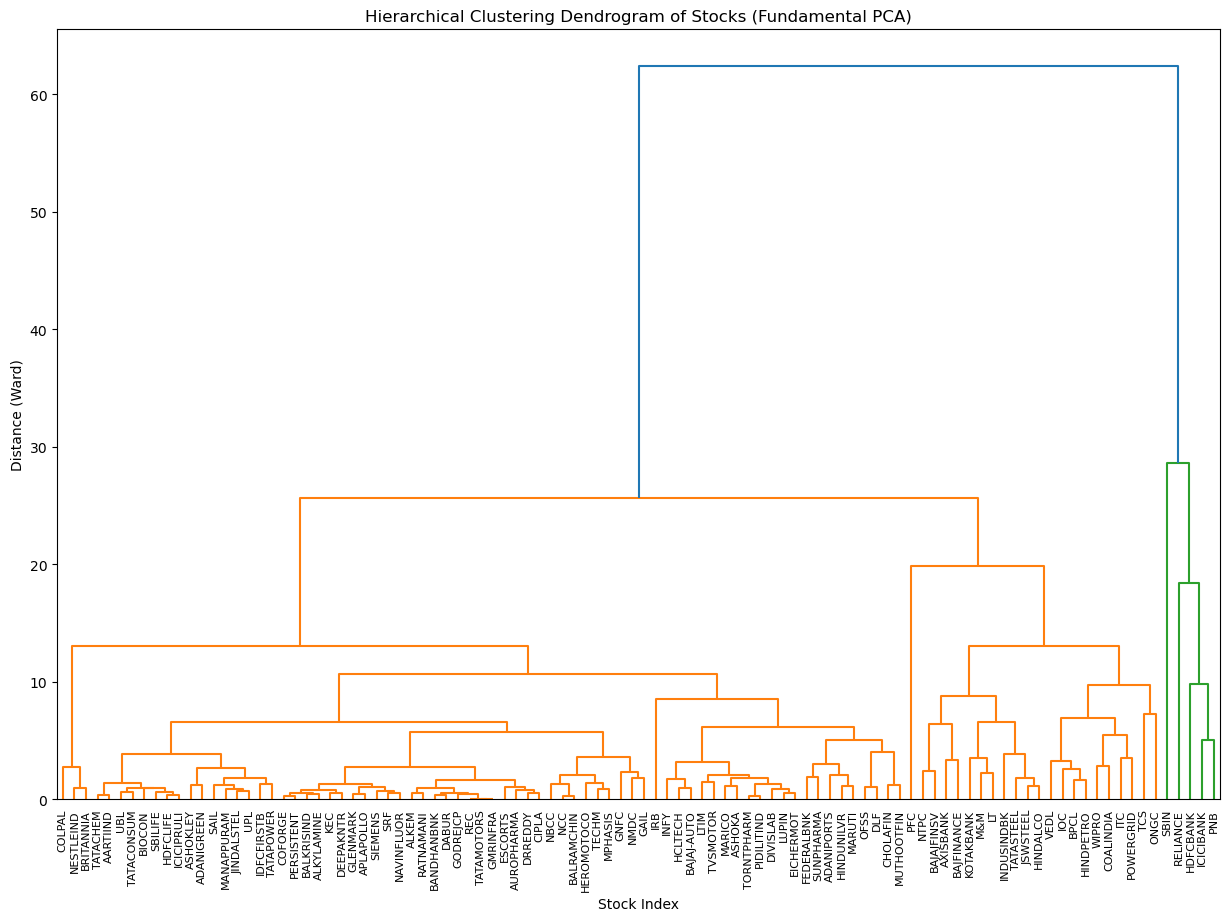

In [ ]:
#51
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(fundamental_pca, method='ward')

plt.figure(figsize=(15, 10))
plt.title("Hierarchical Clustering Dendrogram of Stocks (Fundamental PCA)")
plt.xlabel("Stock Index")
plt.ylabel("Distance (Ward)")

dendrogram(Z,leaf_rotation=90.,leaf_font_size=8.,labels=fundamentals_df['Ticker'].values)
plt.show()

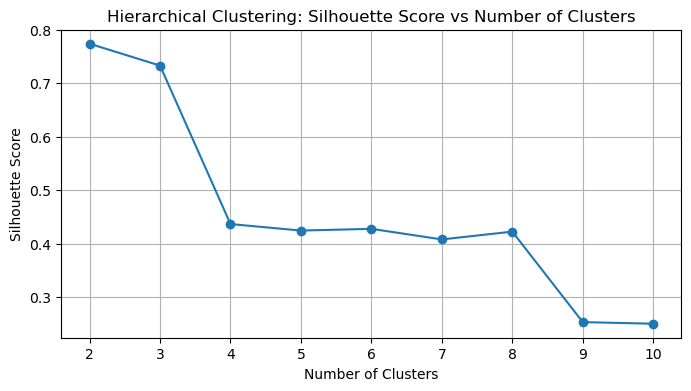

In [ ]:
#52
plt.figure(figsize=(8, 4))
plt.plot(cluster_range,silhouette_scores,marker="o")
plt.title("Hierarchical Clustering: Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
#53
best_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)

print(f"Optimal Number of Clusters: {best_k}")
print(f"Best Silhouette Score: {best_score:.4f}")

Optimal Number of Clusters: 2
Best Silhouette Score: 0.7741


In [ ]:
#54
final_agg = AgglomerativeClustering(n_clusters=best_k,metric="euclidean",linkage="ward")

fundamentals_df["hierarchical_cluster"] = final_agg.fit_predict(fundamental_pca)

fundamentals_df.head()

Sector   Ticker  Market Cap (Cr)  PE Ratio  1Y Return %  ROE %  ROI %  \
0     IT      TCS       1157824.20     24.24       -18.06  42.63  22.51   
1     IT     INFY        674214.29     23.58        -6.23  32.68  15.67   
2     IT    WIPRO        248640.83     18.82       -18.23  15.20   6.74   
3     IT  HCLTECH        467969.66     28.48         5.73  23.19  12.87   
4     IT    TECHM        156106.10     33.78        10.04    NaN    NaN   

   Net Profit Margin %  Dividend Yield %  EBITDA (Cr)  Cash & Equiv (Cr)  \
0                18.30             199.0     68208.00            56743.0   
1                16.15             267.0       438.05              298.5   
2                14.59             724.0     16809.90            57394.9   
3                13.02             314.0       284.90              349.2   
4                 8.39             258.0      7575.77             7278.9   

   Total Debt (Cr)  Beta  start  end  fundamental_cluster  \
0          10821.0  0.30      0   99                    0   
1             97.8  0.26      0   99                    0   
2          19804.6  0.56      0   99                    0   
3             79.1  0.20      0   99                    0   
4           1954.4  0.21      0   99                    0   

   hierarchical_cluster  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [ ]:
#55
fundamentals_df["hierarchical_cluster"].value_counts()

hierarchical_cluster
1    95
0     5
Name: count, dtype: int64

In [ ]:
#56
fundamentals_df.groupby(["hierarchical_cluster","Sector"]).size()

hierarchical_cluster  Sector    
0                     BANKING        4
                      ENERGY         1
1                     AUTO          10
                      BANKING        6
                      CHEMICALS     10
                      ENERGY         9
                      FINANCIALS    10
                      FMCG          10
                      INFRA         10
                      IT            10
                      METAL         10
                      PHARMA        10
dtype: int64

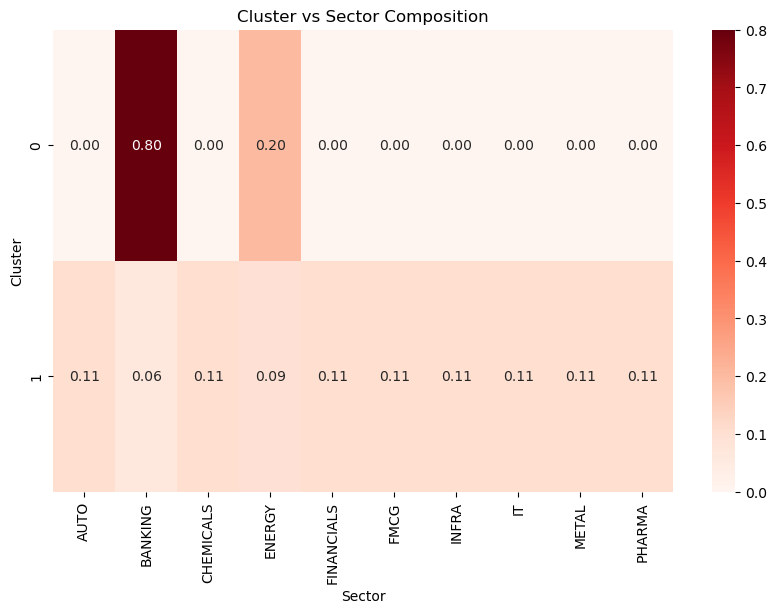

In [ ]:
#57
cluster_sector = pd.crosstab(fundamentals_df['hierarchical_cluster'], fundamentals_df['Sector'], normalize='index')

plt.figure(figsize=(10,6))
sns.heatmap(cluster_sector, cmap="Reds", annot=True, fmt=".2f")
plt.title("Cluster vs Sector Composition")
plt.xlabel("Sector")
plt.ylabel("Cluster")
plt.show()

# Cointegration

In [ ]:
#58
from itertools import combinations

In [ ]:
#59
def test_pair_cointegration(series_a, series_b):

    series_a = series_a.dropna()
    series_b = series_b.dropna()

    joined = pd.concat([series_a, series_b], axis=1).dropna()

    if len(joined) < 100:
        return None

    y = joined.iloc[:,0]
    x = joined.iloc[:,1]

    # Engle-Granger cointegration test
    score, pvalue, critical_values = coint(y, x)

    # hedge ratio via linear regression
    beta = np.polyfit(x, y, 1)[0]

    spread = y - beta * x

    return {
        "pvalue": pvalue,
        "beta": beta,
        "spread_std": spread.std()
    }

In [ ]:
#60
cointegrated_pairs = []
for cluster_id in sorted(fundamentals_df["fundamental_cluster"].unique()):

    cluster_stocks = fundamentals_df.loc[fundamentals_df["fundamental_cluster"] == cluster_id,"Ticker"].tolist()

    print(f"\nProcessing Cluster {cluster_id} — {len(cluster_stocks)} stocks")

    for s1, s2 in combinations(cluster_stocks, 2):

        if s1 not in price_train.columns or s2 not in price_train.columns:
            continue

        result = test_pair_cointegration(
            price_train[s1],
            price_train[s2]
        )

        if result is None:
            continue
        if result["pvalue"] < 0.05:
            cointegrated_pairs.append({
                "cluster": cluster_id,
                "stock_1": s1,
                "stock_2": s2,
                "pvalue": result["pvalue"],
                "beta": result["beta"],
                "spread_std": result["spread_std"]
            })



Processing Cluster 0 — 95 stocks

Processing Cluster 1 — 5 stocks


In [ ]:
#61
pairs_df = pd.DataFrame(cointegrated_pairs)
pairs_df = pairs_df.sort_values("pvalue")
pairs_df.head()

cluster     stock_1     stock_2    pvalue      beta  spread_std
126        0  BANDHANBNK  FEDERALBNK  0.000050 -1.138393   24.842425
203        0      MARICO  BALKRISIND  0.000068  0.156388   28.796120
83         0   KOTAKBANK        NMDC  0.000147 -0.343920   17.133151
88         0   KOTAKBANK  JINDALSTEL  0.000216 -0.024390   17.509307
61         0   KOTAKBANK     DRREDDY  0.000236 -0.025879   17.791564

In [ ]:
#62
pairs_df.shape

(361, 6)

In [ ]:
#63
pairs_df.to_csv("CLUSTERWISE_COINTEGRATED_PAIRS.csv", index=False)
print("CLUSTERWISE_COINTEGRATED_PAIRS.csv")

CLUSTERWISE_COINTEGRATED_PAIRS.csv


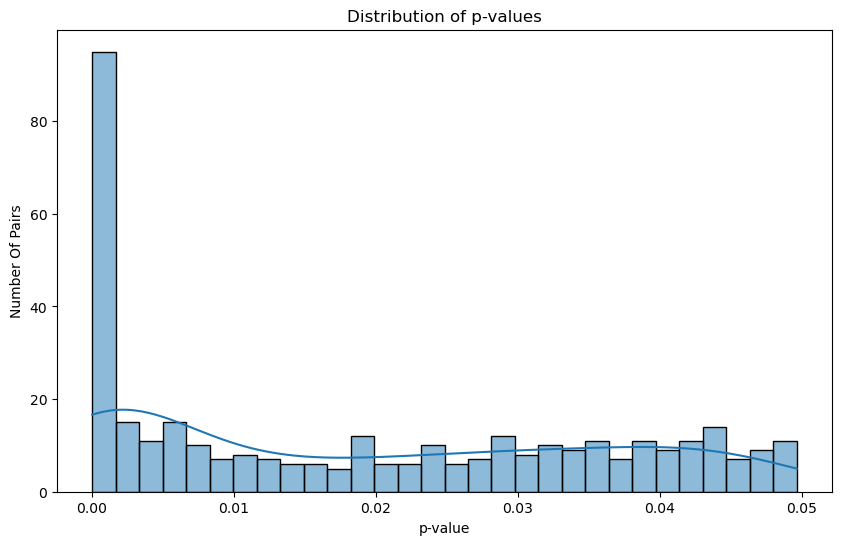

In [ ]:
#64
plt.figure(figsize=(10, 6))
sns.histplot(pairs_df["pvalue"],bins=30,kde=True)
plt.title("Distribution of p-values")

plt.xlabel("p-value")
plt.ylabel("Number Of Pairs")
plt.show()

# Spread & Z Score

In [ ]:
#65
def compute_spread_and_zscore(series_y, series_x, beta):

    spread = series_y - beta * series_x

    spread_mean = spread.mean()
    spread_std  = spread.std()

    zscore = (spread - spread_mean) / spread_std

    return spread, zscore

In [10]:
#65.a 
from IPython.display import Image, display
image_url ="Spread.png"
display(Image(url=image_url, width=400))

In [9]:
#65.b
from IPython.display import Image, display
image_url ="Z_Spread.png"
display(Image(url=image_url, width=400))

In [ ]:
#66
import statsmodels.api as sm
import numpy as np

def compute_half_life(spread):
    if len(spread.dropna()) < 10:
        return np.nan

    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    if spread_lag.nunique() <= 1:
        return np.nan

    spread_ret = spread - spread_lag
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret, spread_lag2, missing='drop')
    result = model.fit()

    lam = np.nan
    if len(result.params) > 1:
        lam = result.params.iloc[1]
    else:
        return np.nan

    if lam == 0:
        return np.nan

    half_life = -np.log(2) / lam

    return max(half_life, 0)

In [ ]:
#67
pair_stats = []

for _, row in pairs_df.iterrows():

    s1 = row["stock_1"]
    s2 = row["stock_2"]
    beta = row["beta"]

    if s1 not in price_train.columns or s2 not in price_train.columns:
        continue

    spread, zscore = compute_spread_and_zscore(
        price_train[s1],
        price_train[s2],
        beta
    )

    half_life = compute_half_life(spread)

    pair_stats.append({
        "cluster": row["cluster"],
        "stock_1": s1,
        "stock_2": s2,
        "pvalue": row["pvalue"],
        "beta": beta,
        "spread_std": row["spread_std"],
        "half_life": half_life,
        "zscore_last": zscore.iloc[-1]
    })


In [ ]:
#68
qualified_pairs_df = pd.DataFrame(pair_stats)
qualified_pairs_df = qualified_pairs_df.sort_values("pvalue")
qualified_pairs_df.head()

cluster     stock_1     stock_2    pvalue      beta  spread_std  half_life  \
0        0  BANDHANBNK  FEDERALBNK  0.000050 -1.138393   24.842425  13.863770   
1        0      MARICO  BALKRISIND  0.000068  0.156388   28.796120  12.872394   
2        0   KOTAKBANK        NMDC  0.000147 -0.343920   17.133151  13.417065   
3        0   KOTAKBANK  JINDALSTEL  0.000216 -0.024390   17.509307  13.966353   
4        0   KOTAKBANK     DRREDDY  0.000236 -0.025879   17.791564  14.433707   

   zscore_last  
0    -0.275778  
1     1.164586  
2    -0.430898  
3    -0.368886  
4    -0.296317

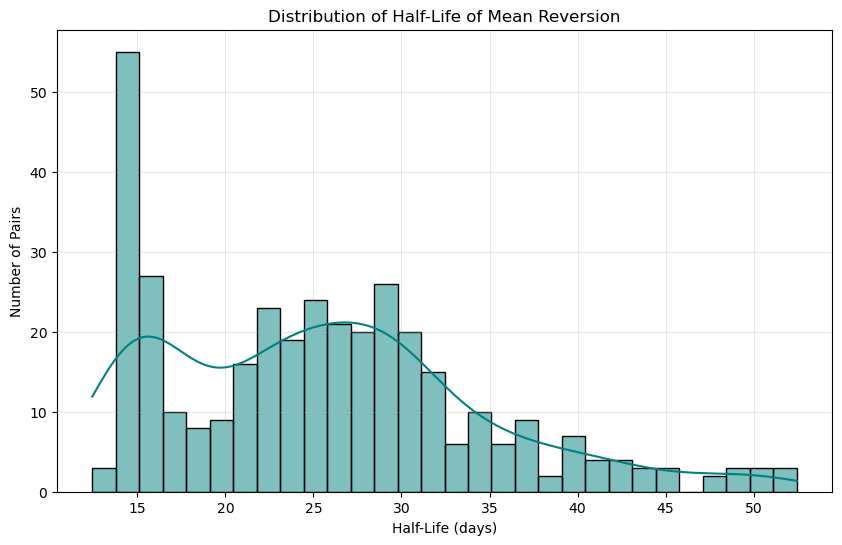

In [ ]:
#69
plt.figure(figsize=(10, 6))

sns.histplot(
    qualified_pairs_df["half_life"],
    bins=30,
    kde=True,
    color="teal",
    edgecolor="black"
)

plt.title("Distribution of Half-Life of Mean Reversion")
plt.xlabel("Half-Life (days)")
plt.ylabel("Number of Pairs")
plt.grid(alpha=0.3)

plt.show()

In [ ]:
#70
tradable_pairs = qualified_pairs_df[
    (qualified_pairs_df["pvalue"] < 0.05) &
    (qualified_pairs_df["half_life"] > 2) &
    (qualified_pairs_df["half_life"] < 60) &
    (qualified_pairs_df["spread_std"] > 0)
].reset_index(drop=True)

tradable_pairs.head()

cluster     stock_1     stock_2    pvalue      beta  spread_std  half_life  \
0        0  BANDHANBNK  FEDERALBNK  0.000050 -1.138393   24.842425  13.863770   
1        0      MARICO  BALKRISIND  0.000068  0.156388   28.796120  12.872394   
2        0   KOTAKBANK        NMDC  0.000147 -0.343920   17.133151  13.417065   
3        0   KOTAKBANK  JINDALSTEL  0.000216 -0.024390   17.509307  13.966353   
4        0   KOTAKBANK     DRREDDY  0.000236 -0.025879   17.791564  14.433707   

   zscore_last  
0    -0.275778  
1     1.164586  
2    -0.430898  
3    -0.368886  
4    -0.296317

In [ ]:
#71
tradable_pairs.shape

(361, 8)

In [ ]:
#72
tradable_pairs.to_csv("TRADABLE_CLUSTERWISE_PAIRS.csv", index=False)
print("Saved → TRADABLE_CLUSTERWISE_PAIRS.csv")

Saved → TRADABLE_CLUSTERWISE_PAIRS.csv


# BackTesting

In [ ]:
#73
def compute_test_spread(stock1, stock2, beta):

    s1 = price_test[stock1]
    s2 = price_test[stock2]

    spread = s1 - beta * s2

    spread_mean = spread.mean()
    spread_std = spread.std()

    zscore = (spread - spread_mean) / spread_std

    return spread, zscore

In [ ]:
#74
def backtest_pair(zscore, s1, s2, beta):

    position = 0
    pnl = []

    for i in range(1, len(zscore)):
        if position == 0:
            if zscore.iloc[i] < -2:
                position = 1
                entry_s1 = s1.iloc[i]
                entry_s2 = s2.iloc[i]

            elif zscore.iloc[i] > 2:
                position = -1
                entry_s1 = s1.iloc[i]
                entry_s2 = s2.iloc[i]

        else:
            if abs(zscore.iloc[i]) < 0.5:
                exit_s1 = s1.iloc[i]
                exit_s2 = s2.iloc[i]

                if position == 1:
                    trade_pnl = (exit_s1 - entry_s1) - beta * (exit_s2 - entry_s2)

                elif position == -1:
                    trade_pnl = -((exit_s1 - entry_s1) - beta * (exit_s2 - entry_s2))

                pnl.append(trade_pnl)

                position = 0

    return np.sum(pnl), len(pnl)

In [ ]:
#75
backtest_results = []

for _, row in tradable_pairs.iterrows():

    s1 = row["stock_1"]
    s2 = row["stock_2"]
    beta = row["beta"]

    if s1 not in price_test.columns or s2 not in price_test.columns:
        print(f"Skipping pair ({s1}, {s2}) as one or both stocks are not in price_test.")
        continue

    spread, zscore = compute_test_spread(s1, s2, beta)

    total_pnl, trades = backtest_pair(
        zscore,
        price_test[s1],
        price_test[s2],
        beta
    )

    backtest_results.append({
        "cluster": row["cluster"],
        "stock_1": s1,
        "stock_2": s2,
        "trades": trades,
        "total_pnl": total_pnl,
        "pvalue": row["pvalue"],
        "half_life": row["half_life"],
        "beta": beta
    })


In [ ]:
#76
results_df = pd.DataFrame(backtest_results)
results_df = results_df.sort_values("total_pnl", ascending=False)
results_df.head()

cluster     stock_1     stock_2  trades    total_pnl    pvalue  \
112        0  BAJAJ-AUTO        NBCC       2  2980.805759  0.003550   
199        0        OFSS   HINDPETRO       1  2561.888545  0.020817   
80         0  BAJAJ-AUTO        GAIL       2  1967.218767  0.000644   
314        0        OFSS      ASHOKA       1  1754.671882  0.042315   
248        0  BAJAJ-AUTO  ADANIPORTS       1  1677.662404  0.030681   

     half_life       beta  
112  22.153703  74.957964  
199  23.490893  30.916880  
80   12.437622  50.168081  
314  17.904129  47.040042  
248  24.108079   8.259873

In [ ]:
#77
profitable_pairs = results_df[
    (results_df["trades"] >= 3) &
    (results_df["total_pnl"] > 0)
].reset_index(drop=True)

profitable_pairs.head()

cluster     stock_1     stock_2  trades    total_pnl    pvalue  half_life  \
0        0   RATNAMANI         UPL       3  1310.142896  0.038767  50.402095   
1        0     ESCORTS          LT       3   995.675720  0.024461  39.888902   
2        0  BALKRISIND   DEEPAKNTR       3   678.200713  0.036364  33.910994   
3        0         UBL  BALKRISIND       3   486.661875  0.041760  29.161754   
4        0       CIPLA   COALINDIA       5   470.027294  0.032852  20.830038   

       beta  
0 -5.542620  
1  1.022105  
2  0.790397  
3  0.503985  
4  1.924871

In [ ]:
#78
all_trade_signals = []

for index, row in profitable_pairs.iterrows():
    s1 = row["stock_1"]
    s2 = row["stock_2"]
    beta = row["beta"]

    spread, zscore = compute_test_spread(s1, s2, beta)

    position = 0
    entry_price_s1 = np.nan
    entry_price_s2 = np.nan
    entry_zscore = np.nan
    entry_date = pd.NaT

    for i in range(len(zscore)):
        current_date = zscore.index[i]
        current_zscore = zscore.iloc[i]
        current_s1_price = price_test[s1].iloc[i]
        current_s2_price = price_test[s2].iloc[i]

        if position == 0:
            if current_zscore < -2:
                position = 1
                entry_date = current_date
                entry_zscore = current_zscore
                entry_price_s1 = current_s1_price
                entry_price_s2 = current_s2_price
            elif current_zscore > 2:
                position = -1
                entry_date = current_date
                entry_zscore = current_zscore
                entry_price_s1 = current_s1_price
                entry_price_s2 = current_s2_price

        else:
            if position == 1 and current_zscore > -0.5:
                exit_date = current_date
                exit_zscore = current_zscore
                exit_price_s1 = current_s1_price
                exit_price_s2 = current_s2_price

                if pd.notna(entry_date):
                    all_trade_signals.append({
                        "pair": f"{s1}-{s2}",
                        "direction": "Long Spread",
                        "entry_date": entry_date.strftime('%Y-%m-%d'),
                        "entry_zscore": entry_zscore,
                        "entry_s1": entry_price_s1,
                        "entry_s2": entry_price_s2,
                        "exit_date": exit_date.strftime('%Y-%m-%d'),
                        "exit_zscore": exit_zscore,
                        "exit_s1": exit_price_s1,
                        "exit_s2": exit_price_s2,
                        "beta": beta
                    })
                position = 0
                entry_date = pd.NaT 
                entry_zscore = np.nan
                entry_price_s1 = np.nan
                entry_price_s2 = np.nan

            # Exit for short spread (z-score crosses below 0.5)
            elif position == -1 and current_zscore < 0.5:
                exit_date = current_date
                exit_zscore = current_zscore
                exit_price_s1 = current_s1_price
                exit_price_s2 = current_s2_price

                if pd.notna(entry_date):
                    all_trade_signals.append({
                        "pair": f"{s1}-{s2}",
                        "direction": "Short Spread",
                        "entry_date": entry_date.strftime('%Y-%m-%d'),
                        "entry_zscore": entry_zscore,
                        "entry_s1": entry_price_s1,
                        "entry_s2": entry_price_s2,
                        "exit_date": exit_date.strftime('%Y-%m-%d'),
                        "exit_zscore": exit_zscore,
                        "exit_s1": exit_price_s1,
                        "exit_s2": exit_price_s2,
                        "beta": beta
                    })
                position = 0
                entry_date = pd.NaT
                entry_zscore = np.nan
                entry_price_s1 = np.nan
                entry_price_s2 = np.nan

trade_signals_df = pd.DataFrame(all_trade_signals)
display(trade_signals_df.head())

pair     direction  entry_date  entry_zscore     entry_s1  \
0  RATNAMANI-UPL   Long Spread  2025-01-28     -2.249352  2784.713867   
1  RATNAMANI-UPL   Long Spread  2025-03-13     -2.159254  2460.665039   
2  RATNAMANI-UPL  Short Spread  2025-07-21      2.136235  2803.056396   
3     ESCORTS-LT  Short Spread  2025-01-30      2.036305  3559.929932   
4     ESCORTS-LT   Long Spread  2025-06-11     -2.066794  3195.520264   

      entry_s2   exit_date  exit_zscore      exit_s1      exit_s2      beta  
0   533.765381  2025-01-31    -0.458876  2841.928467   598.275024 -5.542620  
1   595.995911  2025-03-19    -0.482176  2602.831055   640.439148 -5.542620  
2   713.750000  2025-08-01    -0.051868  2565.549805   665.150024 -5.542620  
3  3389.339844  2025-02-04     0.152082  3272.335938  3407.371582  1.022105  
4  3684.800049  2025-07-03    -0.486066  3348.100098  3582.899902  1.022105

In [ ]:
#79 Define transaction costs
BROKERAGE = 0.0005  # 0.05% brokerage
STT = 0.001         # 0.1% Securities Transaction Tax
GST = 0.00018       # 18% GST on brokerage
SLIPPAGE = 0.0007   # 0.07% slippage

# Total cost rate per trade (entry and exit for both legs)
TOTAL_COST_RATE = (BROKERAGE + STT + GST + SLIPPAGE) * 2

def compute_trade_pnl_simple(entry_y, exit_y,
                             entry_x, exit_x,
                             hedge_ratio,
                             direction):

    # Calculate return on each leg
    if direction == "Long Spread": # Long Y, Short X
        ret_y = (exit_y - entry_y) / entry_y
        ret_x = (entry_x - exit_x) / entry_x
        # Gross return is sum of returns from long Y and short X
        gross_ret = ret_y + (hedge_ratio * ret_x)

    else: # Short Spread (Short Y, Long X)
        ret_y = (entry_y - exit_y) / entry_y
        ret_x = (exit_x - entry_x) / entry_x
        # Gross return is sum of returns from short Y and long X
        gross_ret = ret_y + (hedge_ratio * ret_x)
    trade_cost = TOTAL_COST_RATE
    net_ret = gross_ret - trade_cost

    return gross_ret, net_ret

In [ ]:
#80
trade_log = []

for _, trade in trade_signals_df.iterrows():
    stock1_ticker = trade["pair"].split("-")[0]
    stock2_ticker = trade["pair"].split("-")[1]

    gross_return, net_return = compute_trade_pnl_simple(
        entry_y=trade["entry_s1"],
        exit_y=trade["exit_s1"],
        entry_x=trade["entry_s2"],
        exit_x=trade["exit_s2"],
        hedge_ratio=trade["beta"],
        direction=trade["direction"]
    )

    trade_log.append({
        "Entry Date": trade["entry_date"],
        "Exit Date": trade["exit_date"],
        "Direction": trade["direction"],
        "Stock1": stock1_ticker,
        "Stock2": stock2_ticker,
        "Entry_S1_Price": trade["entry_s1"],
        "Exit_S1_Price": trade["exit_s1"],
        "Entry_S2_Price": trade["entry_s2"],
        "Exit_S2_Price": trade["exit_s2"],
        "Beta": trade["beta"],
        "Gross Return": gross_return,
        "Net Return": net_return
    })

trade_df = pd.DataFrame(trade_log)

if not trade_df.empty:
    trade_df["Entry Date"] = pd.to_datetime(trade_df["Entry Date"])
    trade_df["Exit Date"]  = pd.to_datetime(trade_df["Exit Date"])
    trade_df["Holding Days"] = (trade_df["Exit Date"] - trade_df["Entry Date"]).dt.days
    display(trade_df.head())
else:
    print("No trades to display based on the generated signals.")

Entry Date  Exit Date     Direction     Stock1 Stock2  Entry_S1_Price  \
0 2025-01-28 2025-01-31   Long Spread  RATNAMANI    UPL     2784.713867   
1 2025-03-13 2025-03-19   Long Spread  RATNAMANI    UPL     2460.665039   
2 2025-07-21 2025-08-01  Short Spread  RATNAMANI    UPL     2803.056396   
3 2025-01-30 2025-02-04  Short Spread    ESCORTS     LT     3559.929932   
4 2025-06-11 2025-07-03   Long Spread    ESCORTS     LT     3195.520264   

   Exit_S1_Price  Entry_S2_Price  Exit_S2_Price      Beta  Gross Return  \
0    2841.928467      533.765381     598.275024 -5.542620      0.690414   
1    2602.831055      595.995911     640.439148 -5.542620      0.471087   
2    2565.549805      713.750000     665.150024 -5.542620      0.462134   
3    3272.335938     3389.339844    3407.371582  1.022105      0.086224   
4    3348.100098     3684.800049    3582.899902  1.022105      0.076014   

   Net Return  Holding Days  
0    0.685654             3  
1    0.466327             6  
2    0.457374            11  
3    0.081464             5  
4    0.071254            22

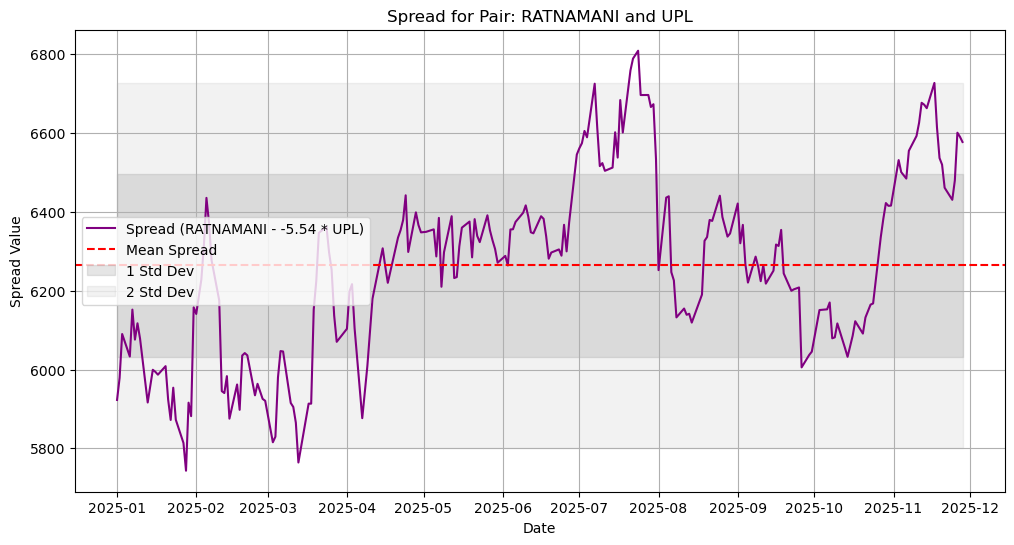

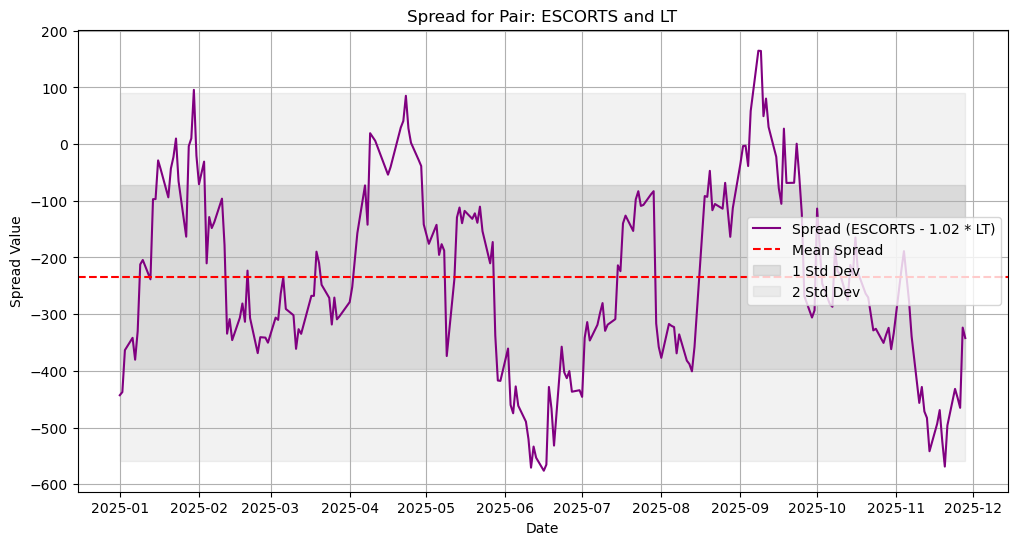

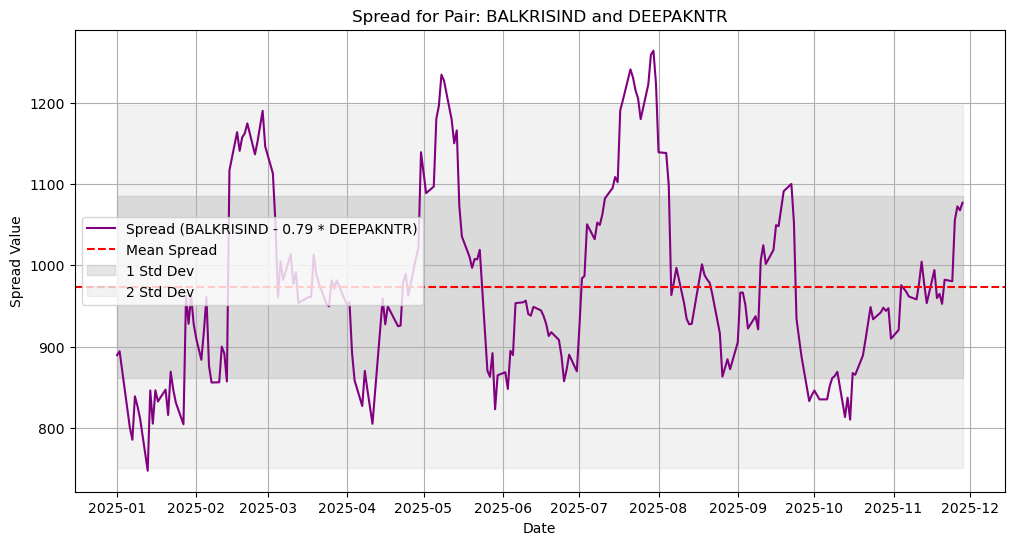

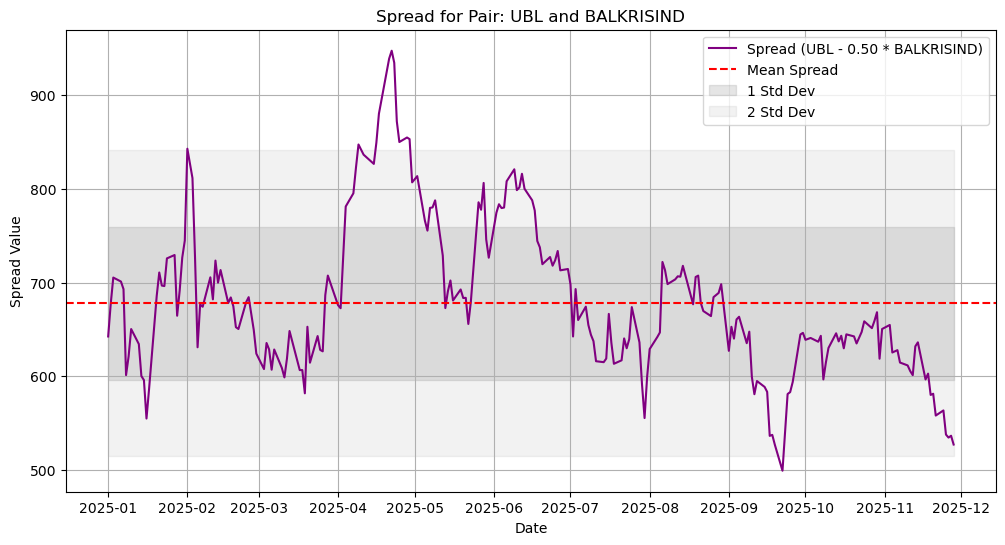

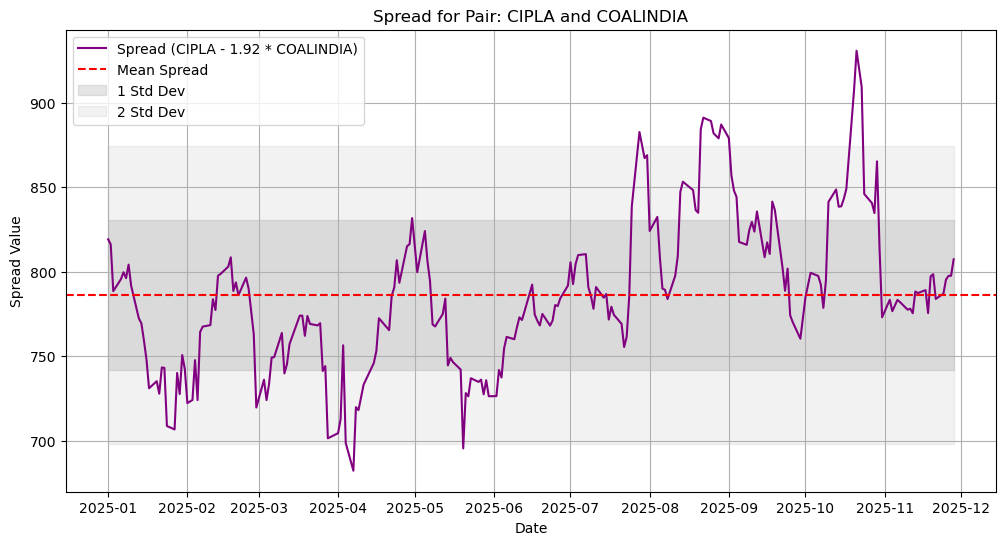

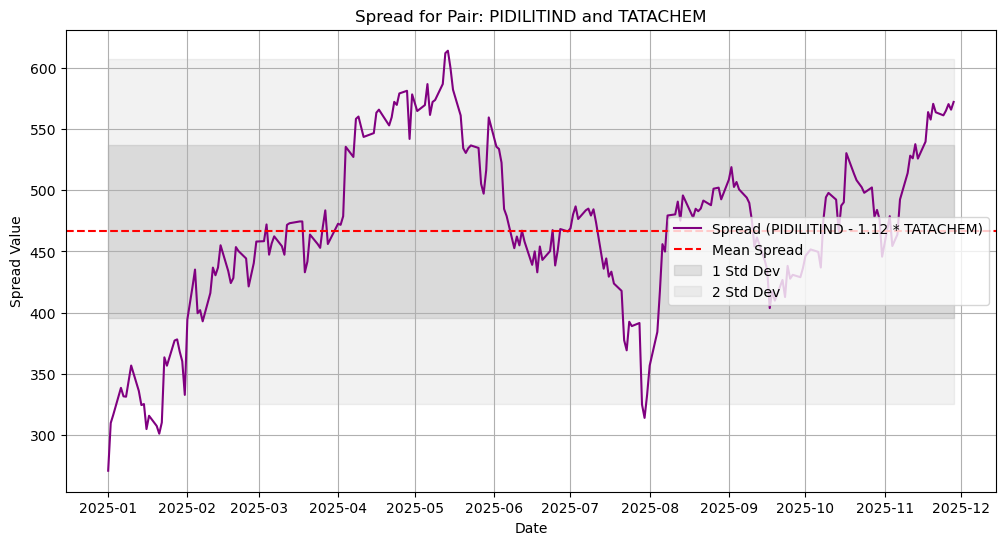

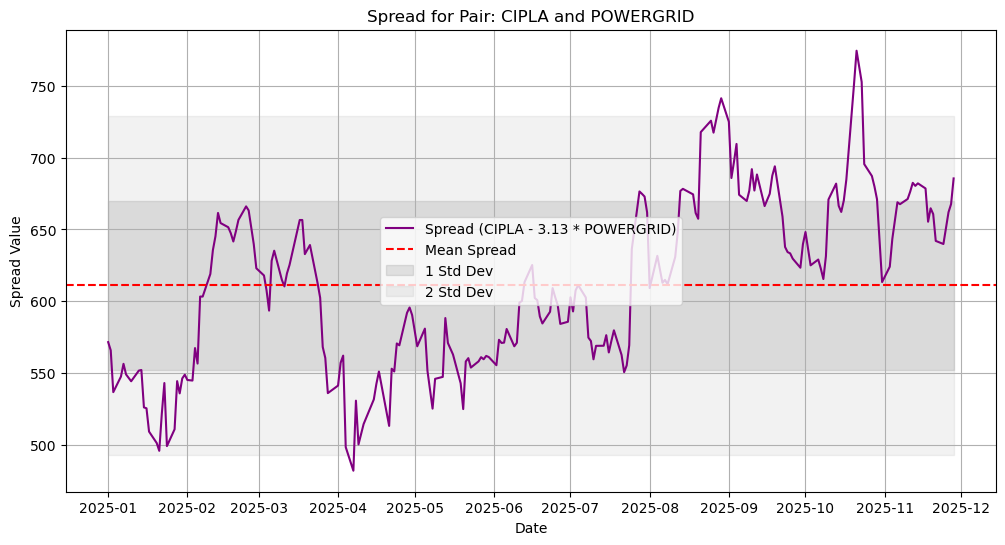

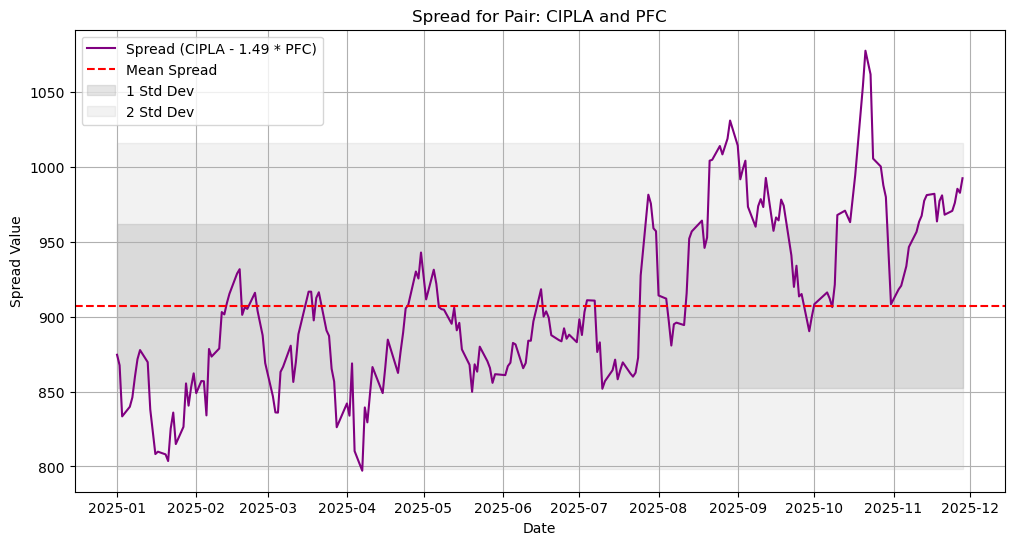

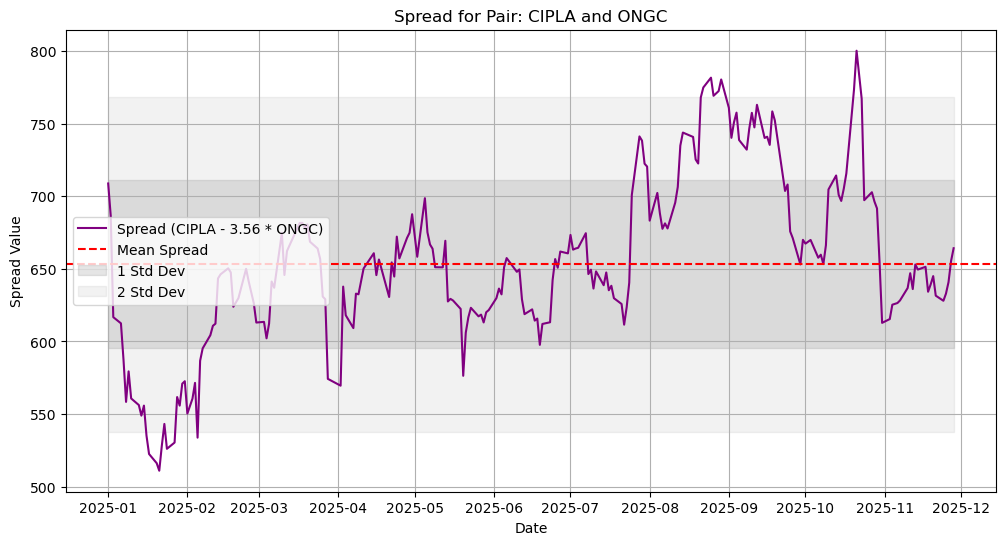

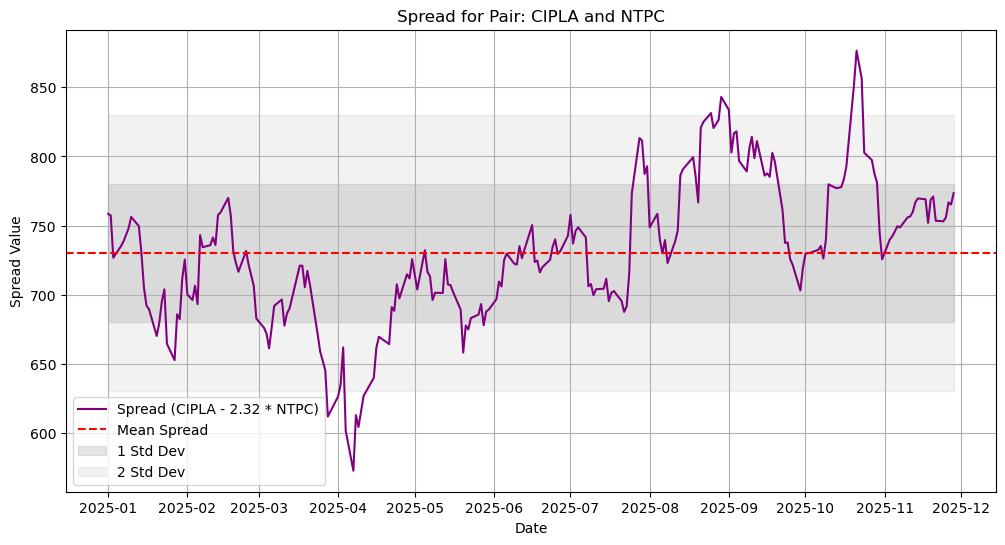

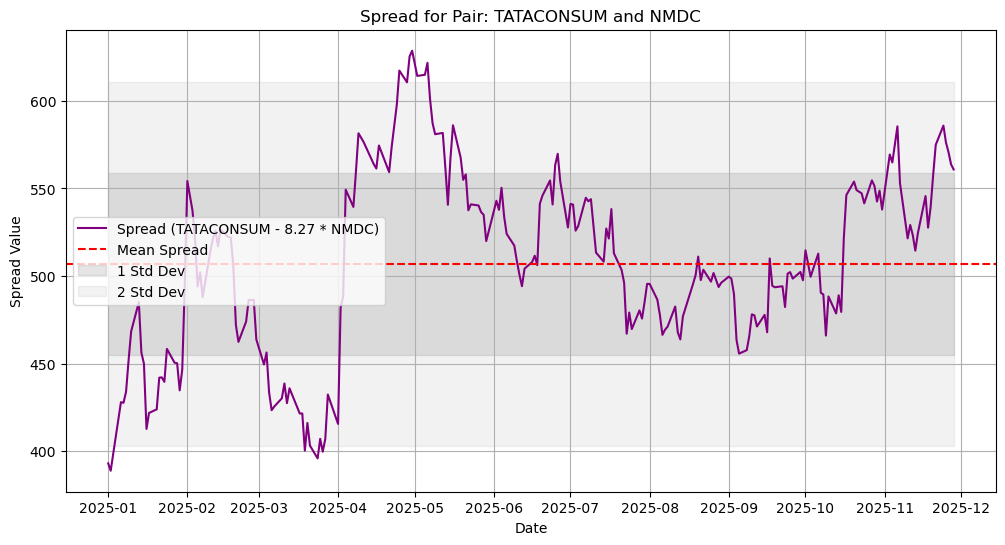

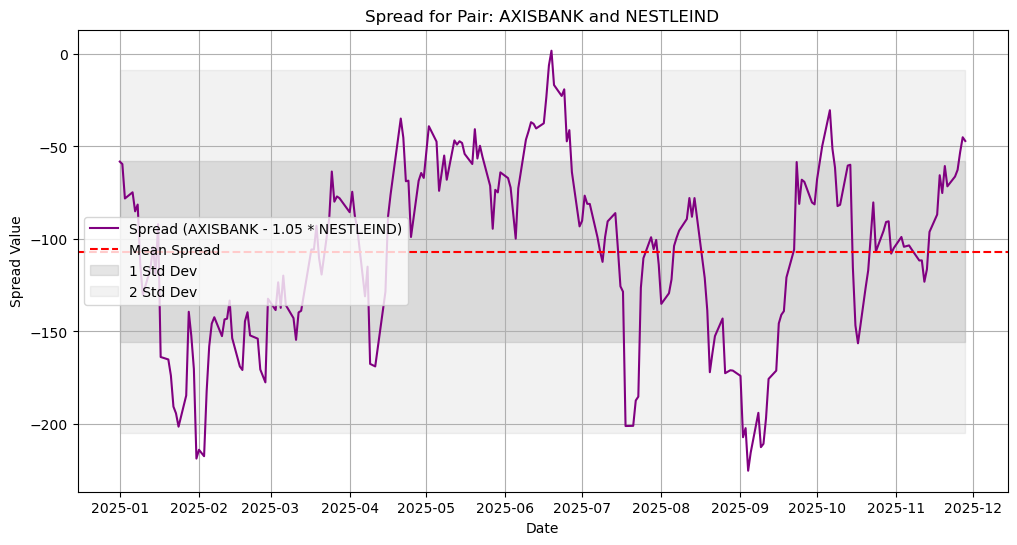

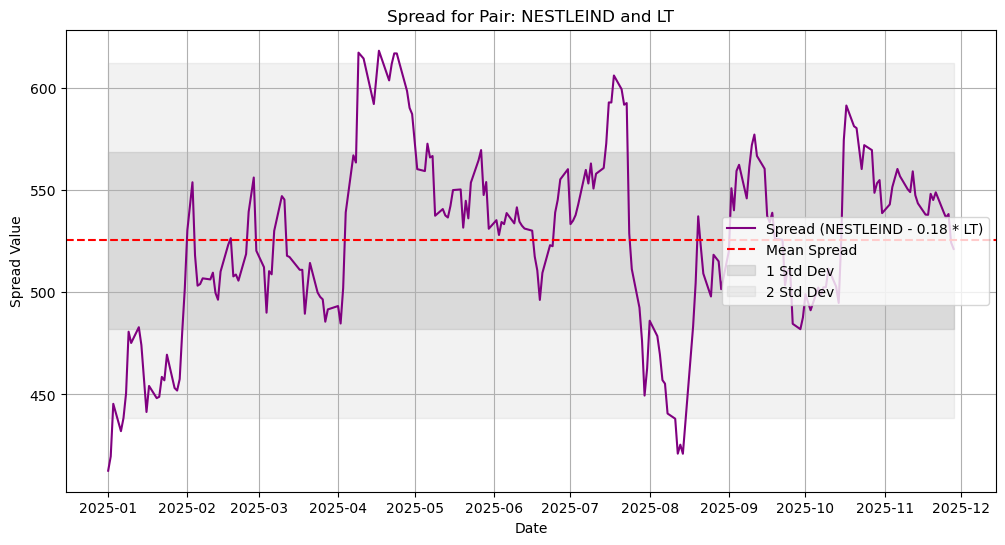

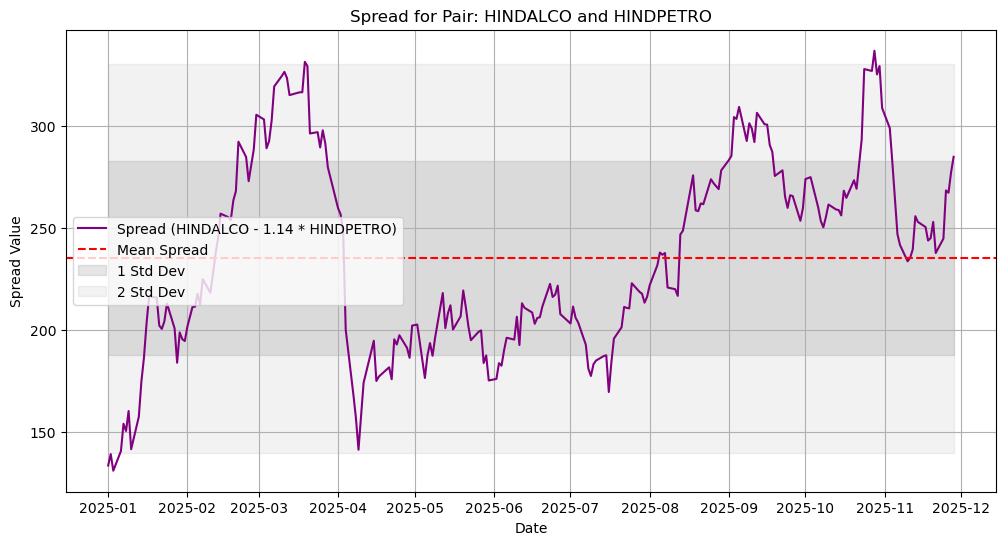

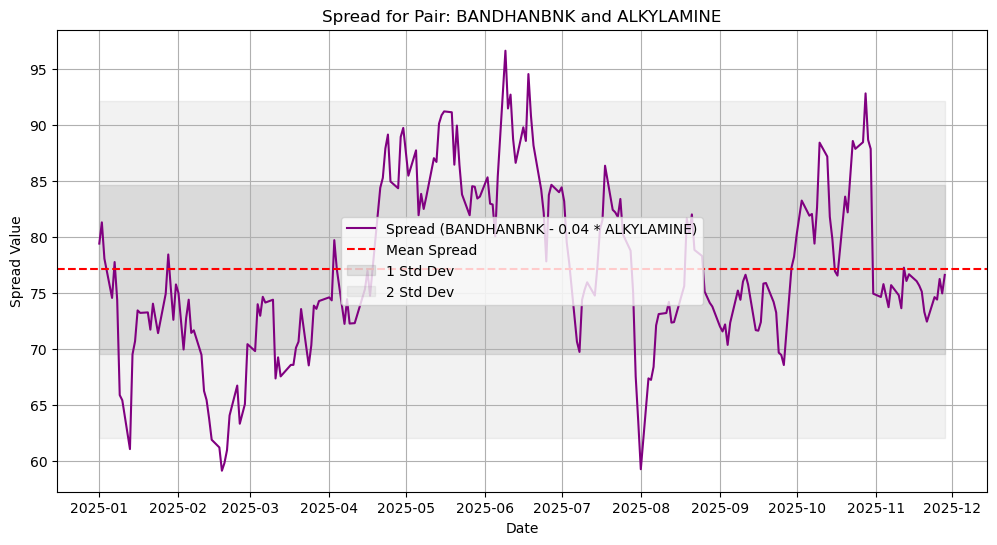

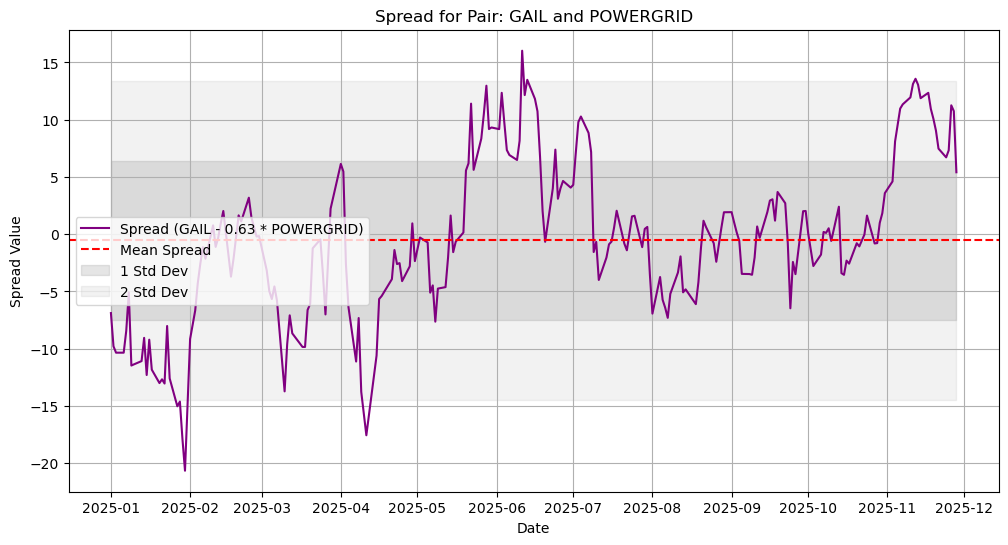

In [ ]:
#81
for index, row in profitable_pairs.iterrows():
    s1 = row["stock_1"]
    s2 = row["stock_2"]
    beta = row["beta"]

    if s1 not in price_test.columns or s2 not in price_test.columns:
        print(f"Skipping visualization for pair ({s1}, {s2}) as one or both stocks are not in price_test.")
        continue

    spread, _ = compute_test_spread(s1, s2, beta)

    plt.figure(figsize=(12, 6))
    plt.plot(spread.index, spread, label=f'Spread ({s1} - {beta:.2f} * {s2})', color='purple')
    plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean Spread')
    plt.fill_between(spread.index, spread.mean() - spread.std(), spread.mean() + spread.std(), color='gray', alpha=0.2, label='1 Std Dev')
    plt.fill_between(spread.index, spread.mean() - 2 * spread.std(), spread.mean() + 2 * spread.std(), color='gray', alpha=0.1, label='2 Std Dev')

    plt.title(f'Spread for Pair: {s1} and {s2}')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid(True)
    plt.show()

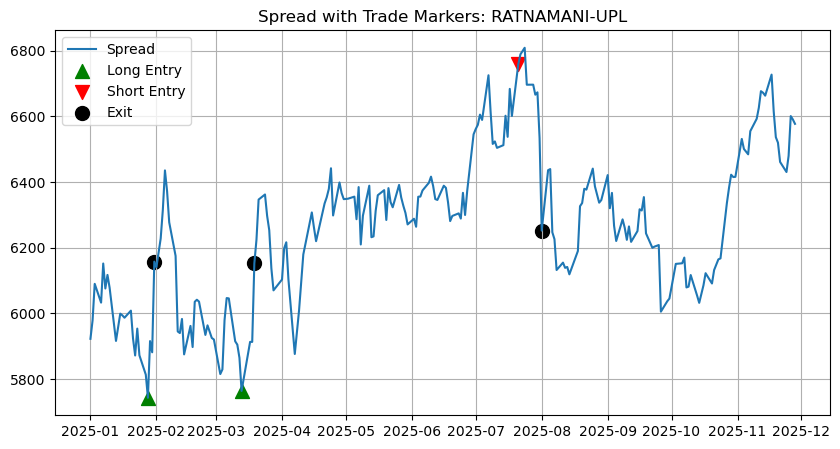

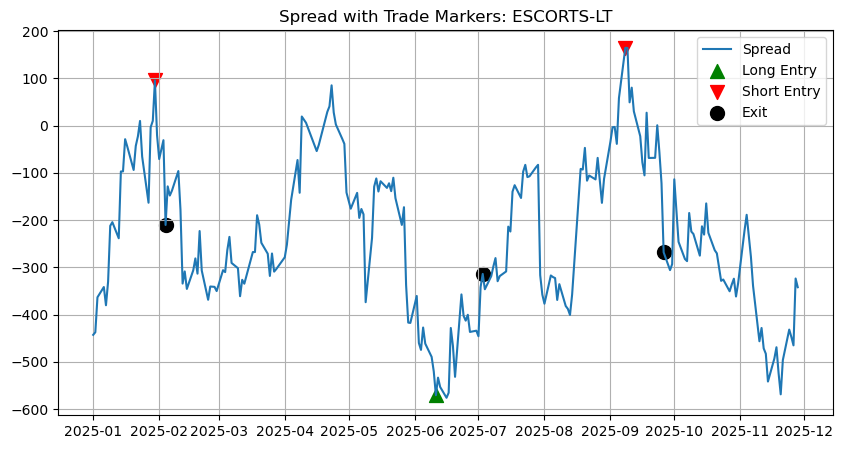

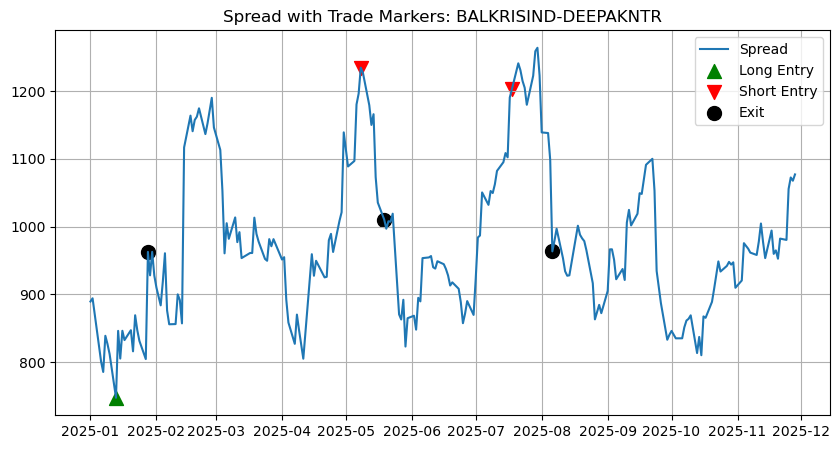

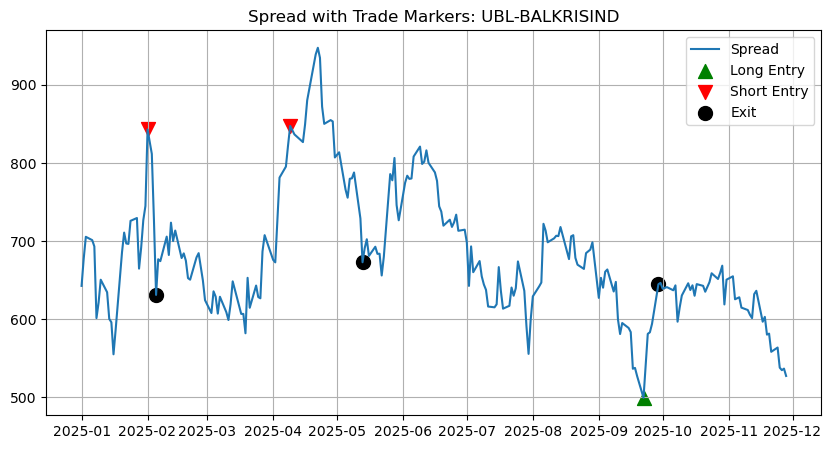

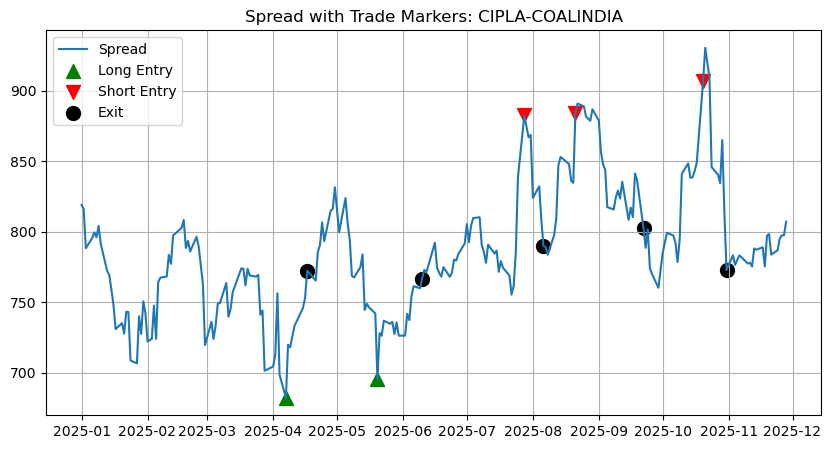

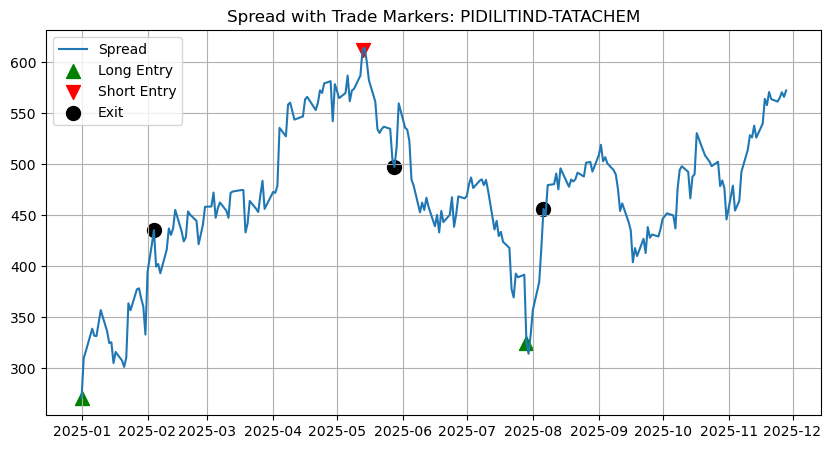

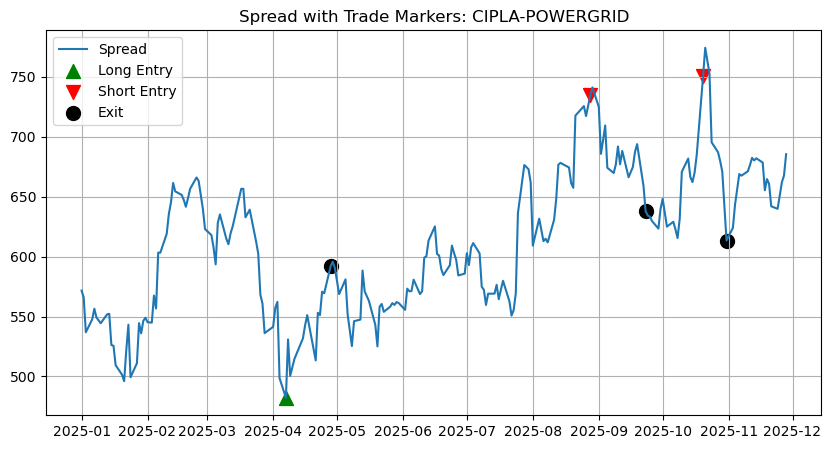

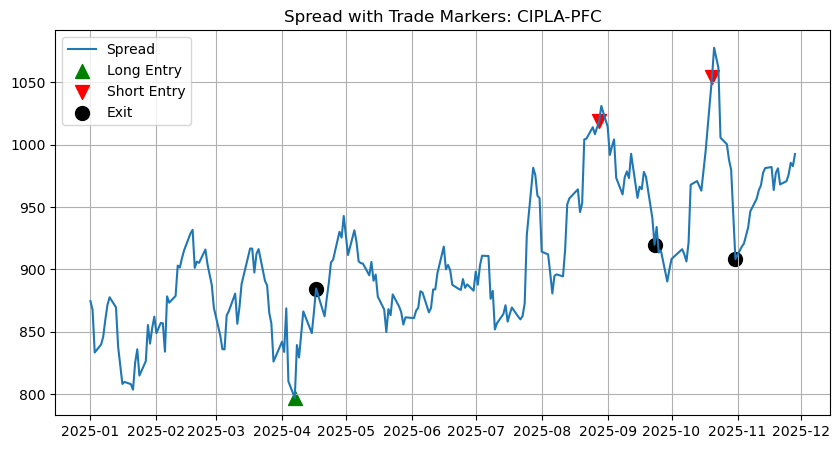

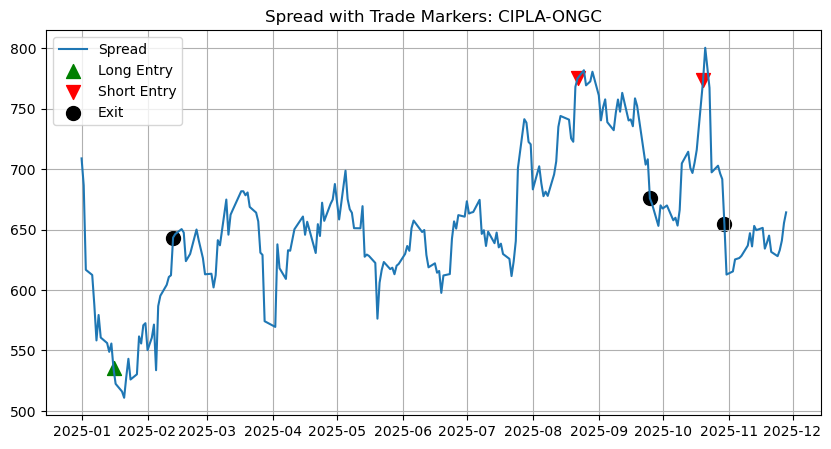

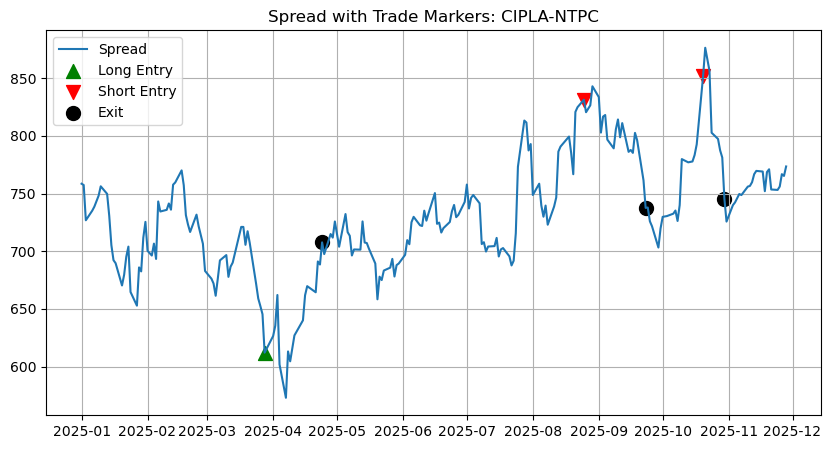

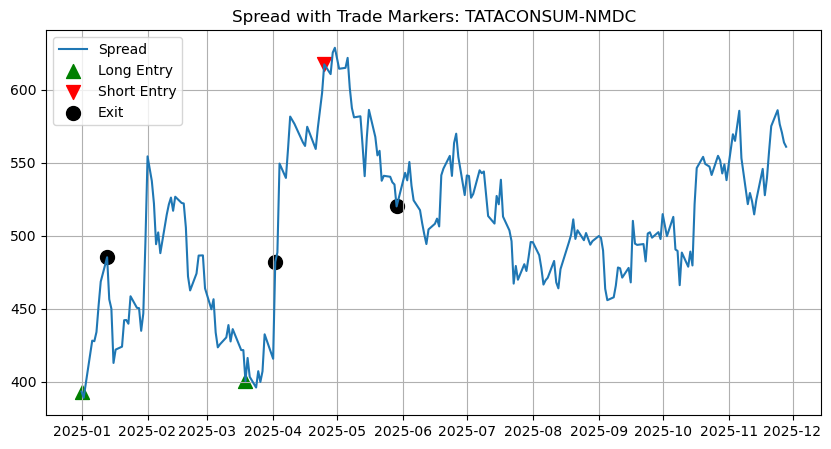

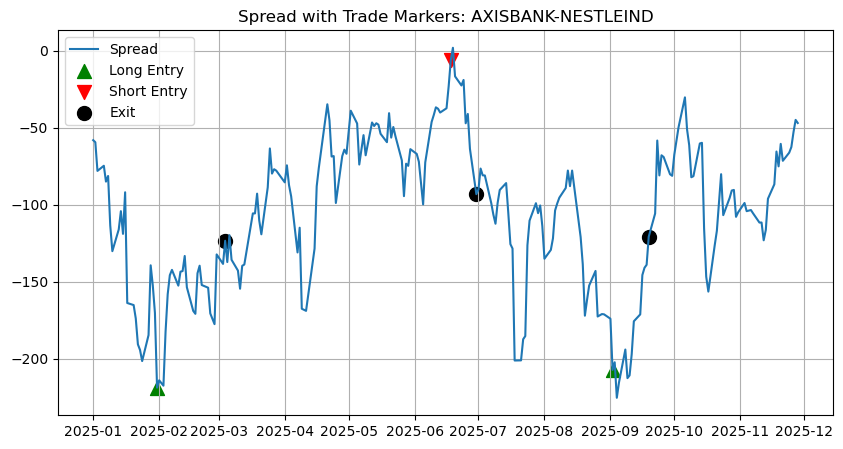

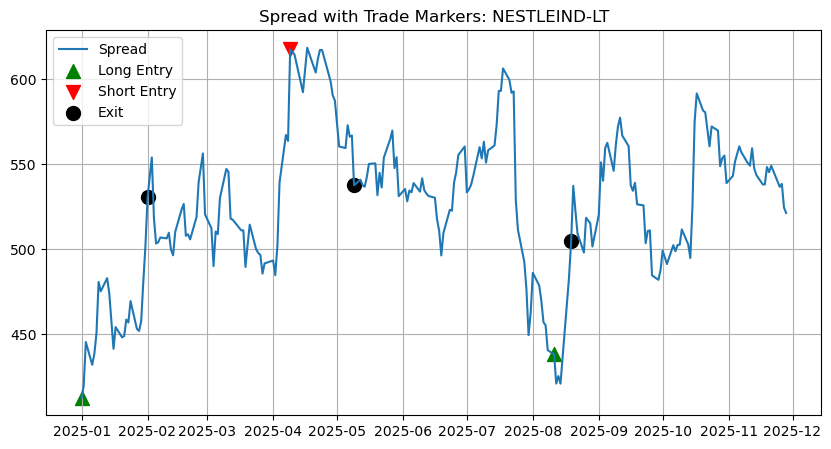

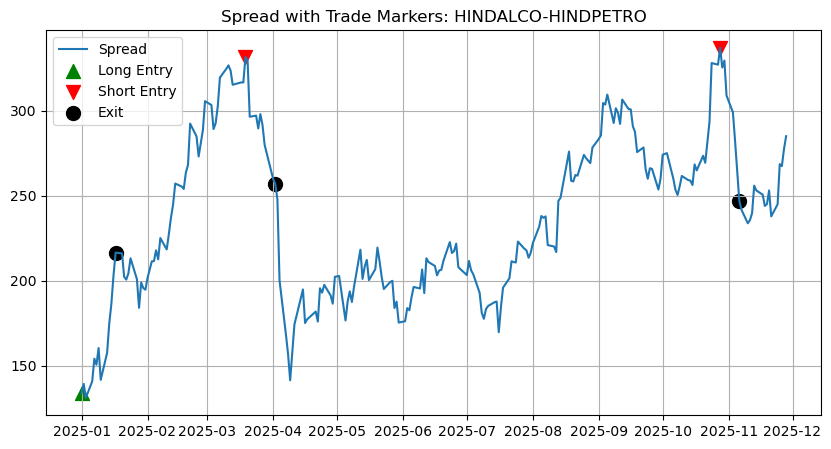

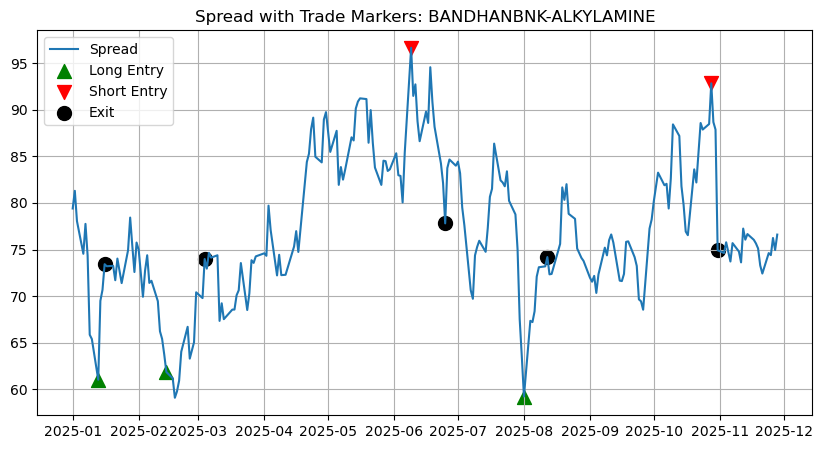

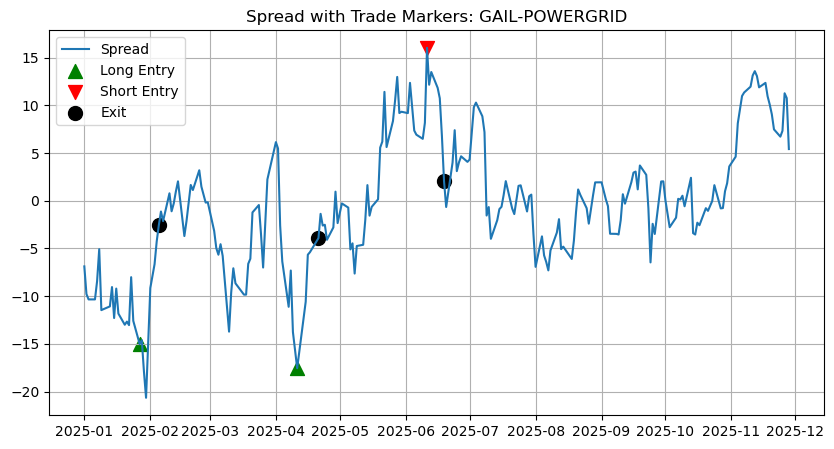

In [ ]:
#82
import matplotlib.pyplot as plt

if 'pair_id' not in trade_df.columns:
    trade_df['pair_id'] = trade_df['Stock1'] + '-' + trade_df['Stock2']

pairs = trade_df['pair_id'].unique()

for pair in pairs:
    df_pair_trades = trade_df[trade_df['pair_id'] == pair].copy()

    s1 = df_pair_trades['Stock1'].iloc[0]
    s2 = df_pair_trades['Stock2'].iloc[0]
    beta = df_pair_trades['Beta'].iloc[0]

    full_spread, full_zscore = compute_test_spread(s1, s2, beta)

    plt.figure(figsize=(10,5))
    plt.plot(full_spread.index, full_spread, label='Spread')

    long_entry_dates = df_pair_trades[df_pair_trades['Direction'] == 'Long Spread']['Entry Date']
    if not long_entry_dates.empty:
        plt.scatter(long_entry_dates, full_spread.loc[long_entry_dates],
                    marker='^', color='green', label='Long Entry', s=100)


    short_entry_dates = df_pair_trades[df_pair_trades['Direction'] == 'Short Spread']['Entry Date']
    if not short_entry_dates.empty:
        plt.scatter(short_entry_dates, full_spread.loc[short_entry_dates],
                    marker='v', color='red', label='Short Entry', s=100)

    exit_dates = df_pair_trades['Exit Date']
    if not exit_dates.empty:
        plt.scatter(exit_dates, full_spread.loc[exit_dates],
                    marker='o', color='black', label='Exit', s=100)

    plt.title(f"Spread with Trade Markers: {pair}")
    plt.legend()
    plt.grid(True)
    plt.show()

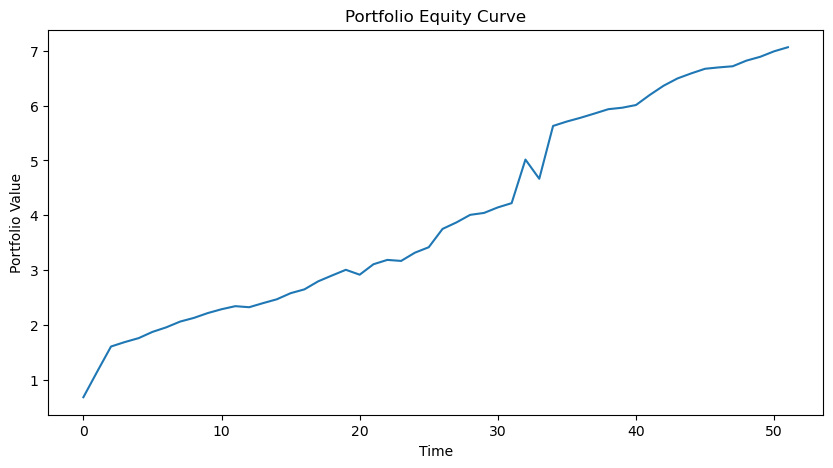

In [ ]:
#83
trade_df["Equity Curve"] = trade_df["Net Return"].cumsum()

plt.figure(figsize=(10,5))
plt.plot(trade_df["Equity Curve"])
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Equity Curve")
plt.show()

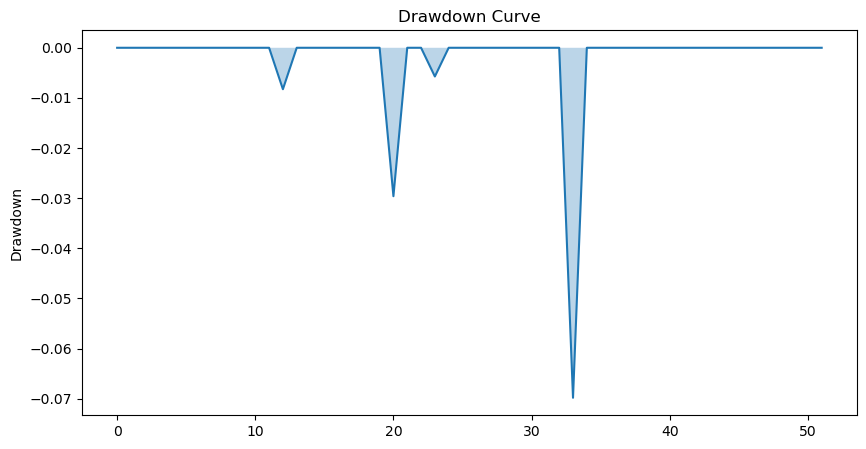

In [ ]:
#84
rolling_max = trade_df["Equity Curve"].cummax()
drawdown = trade_df["Equity Curve"] / rolling_max - 1

plt.figure(figsize=(10,5))
plt.plot(drawdown)
plt.fill_between(drawdown.index, drawdown, 0, alpha=0.3)
plt.title("Drawdown Curve")
plt.ylabel("Drawdown")
plt.show()

In [ ]:
#85  
trade_df.head(15)

Entry Date  Exit Date     Direction      Stock1      Stock2  \
0  2025-01-28 2025-01-31   Long Spread   RATNAMANI         UPL   
1  2025-03-13 2025-03-19   Long Spread   RATNAMANI         UPL   
2  2025-07-21 2025-08-01  Short Spread   RATNAMANI         UPL   
3  2025-01-30 2025-02-04  Short Spread     ESCORTS          LT   
4  2025-06-11 2025-07-03   Long Spread     ESCORTS          LT   
5  2025-09-08 2025-09-26  Short Spread     ESCORTS          LT   
6  2025-01-13 2025-01-28   Long Spread  BALKRISIND   DEEPAKNTR   
7  2025-05-08 2025-05-19  Short Spread  BALKRISIND   DEEPAKNTR   
8  2025-07-18 2025-08-06  Short Spread  BALKRISIND   DEEPAKNTR   
9  2025-02-01 2025-02-05  Short Spread         UBL  BALKRISIND   
10 2025-04-09 2025-05-13  Short Spread         UBL  BALKRISIND   
11 2025-09-22 2025-09-29   Long Spread         UBL  BALKRISIND   
12 2025-04-07 2025-04-17   Long Spread       CIPLA   COALINDIA   
13 2025-05-20 2025-06-10   Long Spread       CIPLA   COALINDIA   
14 2025-07-28 2025-08-06  Short Spread       CIPLA   COALINDIA   

    Entry_S1_Price  Exit_S1_Price  Entry_S2_Price  Exit_S2_Price      Beta  \
0      2784.713867    2841.928467      533.765381     598.275024 -5.542620   
1      2460.665039    2602.831055      595.995911     640.439148 -5.542620   
2      2803.056396    2565.549805      713.750000     665.150024 -5.542620   
3      3559.929932    3272.335938     3389.339844    3407.371582  1.022105   
4      3195.520264    3348.100098     3684.800049    3582.899902  1.022105   
5      3772.300049    3543.699951     3529.600098    3729.500000  1.022105   
6      2579.855713    2689.579590     2318.256348    2184.808594  0.790397   
7      2733.279541    2678.039062     1896.352173    2109.769043  0.790397   
8      2736.635742    2396.098389     1940.868042    1812.500000  0.790397   
9      2224.342773    2047.901367     2740.943604    2811.711426  0.503985   
10     1991.492065    2025.168579     2269.952881    2683.512939  0.503985   
11     1774.900024    1794.800049     2531.666504    2282.393311  0.503985   
12     1370.064453    1499.185059      357.365814     377.577118  1.924871   
13     1439.027832    1494.831665      386.333740     378.239746  1.924871   
14     1572.000000    1486.699951      358.170471     361.996826  1.924871   

    Gross Return  Net Return  Holding Days               pair_id  Equity Curve  
0       0.690414    0.685654             3         RATNAMANI-UPL      0.685654  
1       0.471087    0.466327             6         RATNAMANI-UPL      1.151981  
2       0.462134    0.457374            11         RATNAMANI-UPL      1.609355  
3       0.086224    0.081464             5            ESCORTS-LT      1.690819  
4       0.076014    0.071254            22            ESCORTS-LT      1.762073  
5       0.118487    0.113727            18            ESCORTS-LT      1.875800  
6       0.088029    0.083269            15  BALKRISIND-DEEPAKNTR      1.959069  
7       0.109162    0.104402            11  BALKRISIND-DEEPAKNTR      2.063471  
8       0.072160    0.067400            19  BALKRISIND-DEEPAKNTR      2.130871  
9       0.092335    0.087575             4        UBL-BALKRISIND      2.218447  
10      0.074910    0.070150            34        UBL-BALKRISIND      2.288597  
11      0.060835    0.056075             7        UBL-BALKRISIND      2.344672  
12     -0.014619   -0.019379            10       CIPLA-COALINDIA      2.325293  
13      0.079106    0.074346            21       CIPLA-COALINDIA      2.399639  
14      0.074826    0.070066             9       CIPLA-COALINDIA      2.469705

In [ ]:
#86
trade_df.shape

(52, 15)

# Portfolio Level Optimization

In [ ]:
#87
top_5_pairs = (
    trade_df
    .sort_values("Net Return", ascending=False)
    .head(5)
    .reset_index(drop=True)
)

top_5_pairs

Entry Date  Exit Date     Direction      Stock1 Stock2  Entry_S1_Price  \
0 2025-04-25 2025-05-29  Short Spread  TATACONSUM   NMDC     1147.197632   
1 2025-01-01 2025-01-13   Long Spread  TATACONSUM   NMDC      913.529419   
2 2025-01-28 2025-01-31   Long Spread   RATNAMANI    UPL     2784.713867   
3 2025-03-13 2025-03-19   Long Spread   RATNAMANI    UPL     2460.665039   
4 2025-07-21 2025-08-01  Short Spread   RATNAMANI    UPL     2803.056396   

   Exit_S1_Price  Entry_S2_Price  Exit_S2_Price      Beta  Gross Return  \
0    1109.800049       64.055122      71.293999  8.273364      0.967573   
1     958.347290       62.895283      57.194859  8.273364      0.798905   
2    2841.928467      533.765381     598.275024 -5.542620      0.690414   
3    2602.831055      595.995911     640.439148 -5.542620      0.471087   
4    2565.549805      713.750000     665.150024 -5.542620      0.462134   

   Net Return  Holding Days          pair_id  Equity Curve  
0    0.962813            34  TATACONSUM-NMDC      5.628198  
1    0.794145            12  TATACONSUM-NMDC      5.015488  
2    0.685654             3    RATNAMANI-UPL      0.685654  
3    0.466327             6    RATNAMANI-UPL      1.151981  
4    0.457374            11    RATNAMANI-UPL      1.609355

In [ ]:
#88
TOTAL_CAPITAL = 100_000

In [ ]:
#89
import numpy as np
from itertools import product
weight_grid = np.arange(0.1, 0.6, 0.1)

In [ ]:
#90
pair_returns = top_5_pairs["Net Return"].values

In [ ]:
#91
def portfolio_return(weights, returns, capital):
    weights = np.array(weights)
    invested_amounts = weights * capital
    return np.sum(invested_amounts * returns)

In [ ]:
#92
results = []

for weights in product(weight_grid, repeat=5):

    if np.isclose(sum(weights), 1.0):
        port_ret = portfolio_return(
            weights,
            pair_returns,
            TOTAL_CAPITAL
        )

        results.append({
            "weights": weights,
            "portfolio_return": port_ret
        })


In [ ]:
#93
results_df = (
    pd.DataFrame(results)
    .sort_values("portfolio_return", ascending=False)
    .reset_index(drop=True)
)

best_solution = results_df.iloc[0]
best_solution

weights             (0.5, 0.2, 0.1, 0.1, 0.1)
portfolio_return                 80117.084131
Name: 0, dtype: object

In [ ]:
#94
best_weights = best_solution["weights"]

allocation_df = top_5_pairs[["pair_id", "Net Return"]].copy()
allocation_df["weight"] = best_weights
allocation_df["investment_rs"] = allocation_df["weight"] * TOTAL_CAPITAL
allocation_df["expected_return_rs"] = (
    allocation_df["investment_rs"] * allocation_df["Net Return"]
)

allocation_df

pair_id  Net Return  weight  investment_rs  expected_return_rs
0  TATACONSUM-NMDC    0.962813     0.5        50000.0        48140.639285
1  TATACONSUM-NMDC    0.794145     0.2        20000.0        15882.892475
2    RATNAMANI-UPL    0.685654     0.1        10000.0         6856.541840
3    RATNAMANI-UPL    0.466327     0.1        10000.0         4663.270004
4    RATNAMANI-UPL    0.457374     0.1        10000.0         4573.740527

In [ ]:
#95
print("Best Portfolio Return (Rs):", round(best_solution["portfolio_return"], 2))
print("Total Capital Used (Rs):", TOTAL_CAPITAL)

Best Portfolio Return (Rs): 80117.08
Total Capital Used (Rs): 100000


In [ ]:
#96
start_date = train_prices.index.min()
end_date = test_prices.index.max()

num_years = (end_date - start_date).days / 365.25

print("Start date:", start_date.date())
print("End date:", end_date.date())
print("Number of years used:", round(num_years, 2))

Start date: 2021-01-01
End date: 2025-11-28
Number of years used: 4.91


In [ ]:
#97
initial_capital = 100_000
final_portfolio_value = initial_capital + best_solution["portfolio_return"]

total_return = (final_portfolio_value / initial_capital) - 1
print("Total Return:", round(total_return * 100, 2), "%")

Total Return: 80.12 %


In [ ]:
#98
cagr = (final_portfolio_value / initial_capital) ** (1 / num_years) - 1

print("CAGR (Average Annual Return):", round(cagr * 100, 2), "%")

CAGR (Average Annual Return): 12.74 %


# Trade Level Optimization

In [ ]:
#99
trade_stats = {}

trade_stats["Total Trades"] = len(trade_df)

trade_stats["Win Rate %"] = round(
    (trade_df["Net Return"] > 0).mean() * 100, 2
)

trade_stats["Avg Gross Return %"] = round(
    trade_df["Gross Return"].mean() * 100, 3
)

trade_stats["Avg Net Return %"] = round(
    trade_df["Net Return"].mean() * 100, 3
)

trade_stats["Profit Factor"] = round(
    trade_df.loc[trade_df["Net Return"] > 0, "Net Return"].sum() /
    abs(trade_df.loc[trade_df["Net Return"] < 0, "Net Return"].sum()),
    3
)

trade_stats["Avg Holding Days"] = round(
    trade_df["Holding Days"].mean(), 2
)

pd.Series(trade_stats)

Total Trades          52.000
Win Rate %            92.310
Avg Gross Return %    14.057
Avg Net Return %      13.581
Profit Factor         15.813
Avg Holding Days      16.250
dtype: float64

In [ ]:
#100
trade_df["Equity Curve"] = trade_df["Net Return"].cumsum()

max_equity = trade_df["Equity Curve"].cummax()
drawdown = trade_df["Equity Curve"] - max_equity
max_dd = drawdown.min()

risk_summary = {}

risk_summary["Total Net Return %"] = round(
    trade_df["Net Return"].sum() * 100, 2
)

risk_summary["Max Drawdown %"] = round(
    max_dd * 100, 2
)

risk_summary["Sharpe (approx)"] = round(
    trade_df["Net Return"].mean() /
    trade_df["Net Return"].std(),
    3
)

pd.Series(risk_summary)

Total Net Return %    706.230
Max Drawdown %        -35.010
Sharpe (approx)         0.661
dtype: float64

In [ ]:
#101
fundamentals_df.to_csv("fundamentals.csv", index=False)
trade_df.to_csv("trade_df.csv", index=False)